In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import folium
from folium import plugins
import geopandas as gpd
import branca

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import ttest_ind

plt.rcParams["font.family"] = "monospace"
plt.rcParams['figure.dpi'] = 150
background_color='#F5F4EF'

# Print colored text 
# https://stackoverflow.com/questions/287871/how-to-print-colored-text-to-the-terminal
# Includes other color options

HEADER = '\033[95m'
OKBLUE = '\033[94m'
OKCYAN = '\033[96m'
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'

class color_font:
    S = BOLD + OKBLUE +  UNDERLINE   #S = Start
    E = ENDC #E = End
    
print(color_font.S+"Datasets & Libraries loaded"+color_font.E)

input\120-years-of-olympic-history-athletes-and-results\athlete_events.csv
input\120-years-of-olympic-history-athletes-and-results\noc_regions.csv
input\2021-olympics-in-tokyo\Athletes.xlsx
input\2021-olympics-in-tokyo\Coaches.xlsx
input\2021-olympics-in-tokyo\EntriesGender.xlsx
input\2021-olympics-in-tokyo\Medals.xlsx
input\2021-olympics-in-tokyo\Teams.xlsx
input\olympic-games-2021-medals\Tokyo 2021 dataset.csv
input\population-by-country-2020\population_by_country_2020.csv
Datasets & Libraries loaded


In [4]:
population = pd.read_csv('input/population-by-country-2020/population_by_country_2020.csv')
regions = pd.read_csv('input/120-years-of-olympic-history-athletes-and-results/noc_regions.csv')

df = pd.read_csv('input/120-years-of-olympic-history-athletes-and-results/athlete_events.csv')
df_21 = pd.read_csv('input/olympic-games-2021-medals/Tokyo 2021 dataset.csv')
df_21_full = pd.read_csv('input/olympic-games-2021-medals/Tokyo 2021 dataset.csv')


# For geographic plotting
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'

# **Tokyo 2021**

Before delving in to my investigation, let's take a look at how the medals table finished at Tokyo 2020 (2021).

We see familiar nations at the top: The USA, China, the United Kingdom, and notably, **Japan**.

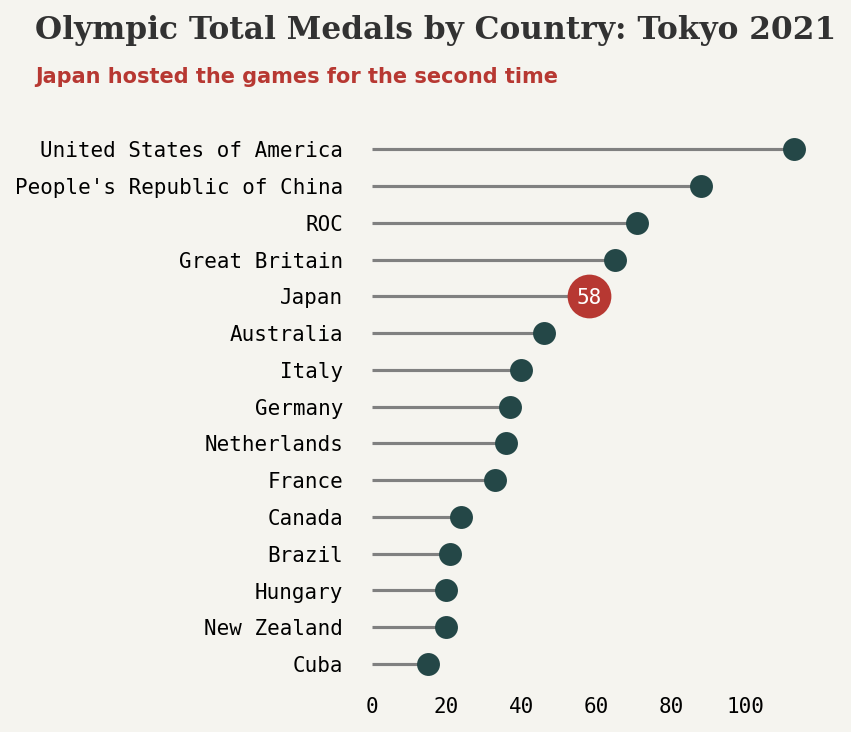

In [3]:

fig, ax = plt.subplots(figsize=(4, 5), facecolor=background_color)

temp = df_21_full[:15].sort_values(by='Total')
my_range=range(1,len(df_21_full[:15]['Team/NOC'])+1)


ax.set_facecolor(background_color)

#B73832



plt.hlines(y=my_range, xmin=0, xmax=temp['Total'], color='gray')
plt.plot(temp['Total'], my_range, "o",markersize=10, color='#244747')
plt.plot(temp['Total'][2], my_range[10], "o",markersize=20,color='#B73832')


Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel("Total Medals",fontfamily='monospace',loc='left',color='gray')
ax.set_axisbelow(True)


for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
    


ax.text(-90,Yend+2.3, 'Olympic Total Medals by Country: Tokyo 2021', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(-90,Yend+1.1, 'Japan hosted the games for the second time', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')
#ax.text(-100,Yend+1, 'Not Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#244747')



# Add titles and axis names
plt.yticks(my_range, temp['Team/NOC'])
plt.xlabel('')


ax.annotate(temp['Total'][2], xy=(54.86,10.95), va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=10, color='white',rotation=0)

# Show the plot
plt.show()

Let's take a more detailed view at the medal tables, breaking down the medals into bronze, silver, and gold.

In [4]:
def highlight(nation):
    if nation['Team/NOC'] == 'Japan':
        return ['background-color: #f3f2f1']*6
    else:
        return ['background-color: white']*6

df_21_full[['Rank','Team/NOC','Bronze Medal','Silver Medal','Gold Medal','Total']].iloc[:15].style.set_caption('Medals by Country: Summer Olympic Games sorted by Gold Medals [Top 15]')\
.bar(subset=['Gold Medal'], color='#f0c05a')\
.bar(subset=['Silver Medal'], color='Lightgray')\
.bar(subset=['Bronze Medal'], color='#a97142')\
.hide_index().apply(highlight, axis=1)

Rank,Team/NOC,Bronze Medal,Silver Medal,Gold Medal,Total
1,United States of America,33,41,39,113
2,People's Republic of China,18,32,38,88
3,Japan,17,14,27,58
4,Great Britain,22,21,22,65
5,ROC,23,28,20,71
6,Australia,22,7,17,46
7,Netherlands,14,12,10,36
8,France,11,12,10,33
9,Germany,16,11,10,37
10,Italy,20,10,10,40


# **Next Steps**

**Data Engineering**

Before I can analyse the data over the years, I first need to do some data engineering.

I'll first create a polygon for each country which I will be able to use later when I plot a geographic visual - showing which countries have hosted the Olympics, and where medals tend to go.

I'll also join several datasets together and do some feature engineering to enable the joins to work correctly.

In [5]:
# For geographic plotting
global_polygons = gpd.read_file(country_shapes)
global_polygons.to_file('global_polygons.geojson', driver = 'GeoJSON')

#global_polygons.plot(figsize=(10,5)) we now have a map of the globe

# Tabular
df = pd.merge(df,regions,left_on='NOC',right_on='NOC')
df = df.query('Season == "Summer"') # Only interested in Summer Olympics for this project

In [6]:
#Replacing the country name with common values
df.replace('USA', "United States of America", inplace = True)
df.replace('Tanzania', "United Republic of Tanzania", inplace = True)
df.replace('Democratic Republic of Congo', "Democratic Republic of the Congo", inplace = True)
df.replace('Congo', "Republic of the Congo", inplace = True)
df.replace('Lao', "Laos", inplace = True)
df.replace('Syrian Arab Republic', "Syria", inplace = True)
df.replace('Serbia', "Republic of Serbia", inplace = True)
df.replace('Czechia', "Czech Republic", inplace = True)
df.replace('UAE', "United Arab Emirates", inplace = True)
df.replace('UK', "United Kingdom", inplace = True)

population.replace('United States', "United States of America", inplace = True)
population.replace('Czech Republic (Czechia)', "Czech Republic", inplace = True)
population.replace('DR Congo', "Democratic Republic of the Congo", inplace = True)
population.replace('Serbia', "Republic of Serbia", inplace = True)
population.replace('Tanzania', "United Republic of Tanzania", inplace = True)

df_21_full.replace('Great Britain', "United Kingdom", inplace = True)
df_21_full.replace("People's Republic of China", "China", inplace = True)
df_21_full.replace("ROC", "Russia", inplace = True)


In [7]:
# Function to map country to city

def host_country(col):
    if col == "Rio de Janeiro":
        return "Brazil"
    elif col == "London":
        return "United Kingdom"
    elif col == "Beijing":
        return  "China"
    elif col == "Athina":
        return  "Greece"
    elif col == "Sydney" or col == "Melbourne":
        return  "Australia"
    elif col == "Atlanta" or col == "Los Angeles" or col == "St. Louis":
        return  "United States of America"
    elif col == "Barcelona":
        return  "Spain"
    elif col == "Seoul":
        return  "South Korea"
    elif col == "Moskva":
        return  "Russia"
    elif col == "Montreal":
        return  "Canada"
    elif col == "Munich" or col == "Berlin":
        return  "Germany"
    elif col == "Mexico City":
        return  "Mexico"
    elif col == "Tokyo":
        return  "Japan"
    elif col == "Roma":
        return  "Italy"
    elif col == "Paris":
        return  "France"
    elif col == "Helsinki":
        return  "Finland"
    elif col == "Amsterdam":
        return  "Netherlands"
    elif col == "Antwerpen":
        return  "Belgium"
    elif col == "Stockholm":
        return  "Sweden"
    else:
        return "Other"


# Applying this function

df['Host_Country'] = df['City'].apply(host_country)

Ceeating a new dataframe containing host nation data

In [8]:
df_new = df.groupby(['Year','Host_Country','region','Medal'])['Medal'].count().unstack().fillna(0).astype(int).reset_index()

df_new['Is_Host'] = np.where(df_new['Host_Country'] == df_new['region'],1,0)
df_new['Total Medals'] = df_new['Bronze'] + df_new['Silver'] + df_new['Gold']

# **Hosting The Olympics**

In [9]:
# Preparing to add 2021 data to our historic df

df_21_full_refined = df_21_full[['Team/NOC', "Gold Medal", "Silver Medal", "Bronze Medal"]]
df_21_full_refined['Total Medals'] = df_21_full_refined[["Gold Medal", "Silver Medal", "Bronze Medal"]].sum(axis=1)
df_21_full_refined['Year'] = 2021

df_21_full_refined = df_21_full_refined.rename(columns={'Gold Medal':'Gold', 'Silver Medal':'Silver','Bronze Medal':'Bronze'})

df_21_full_refined['Is_Host'] = np.where(df_21_full_refined['Team/NOC'] == 'Japan',1,0)
df_21_full_refined['Host_Country'] = 'Japan'
df_21_full_refined = df_21_full_refined.rename(columns={'Team/NOC':'region'})

# Adding 2021 data to historic
df_new = df_new.append(df_21_full_refined)

# Removing Russia as many Olympic games were competed in as the Soviet Union, containing several modern day nations

df_new = df_new.query("region != 'Russia' | region != 'ROC'")

Hosting the olympics is an incredible honor for a country to have.

The previous three Olympics were hosted by: Japan, Brazil, and the United Kingdom.

Here's an overview of their Olympic histories, with the years they hosted highlighted

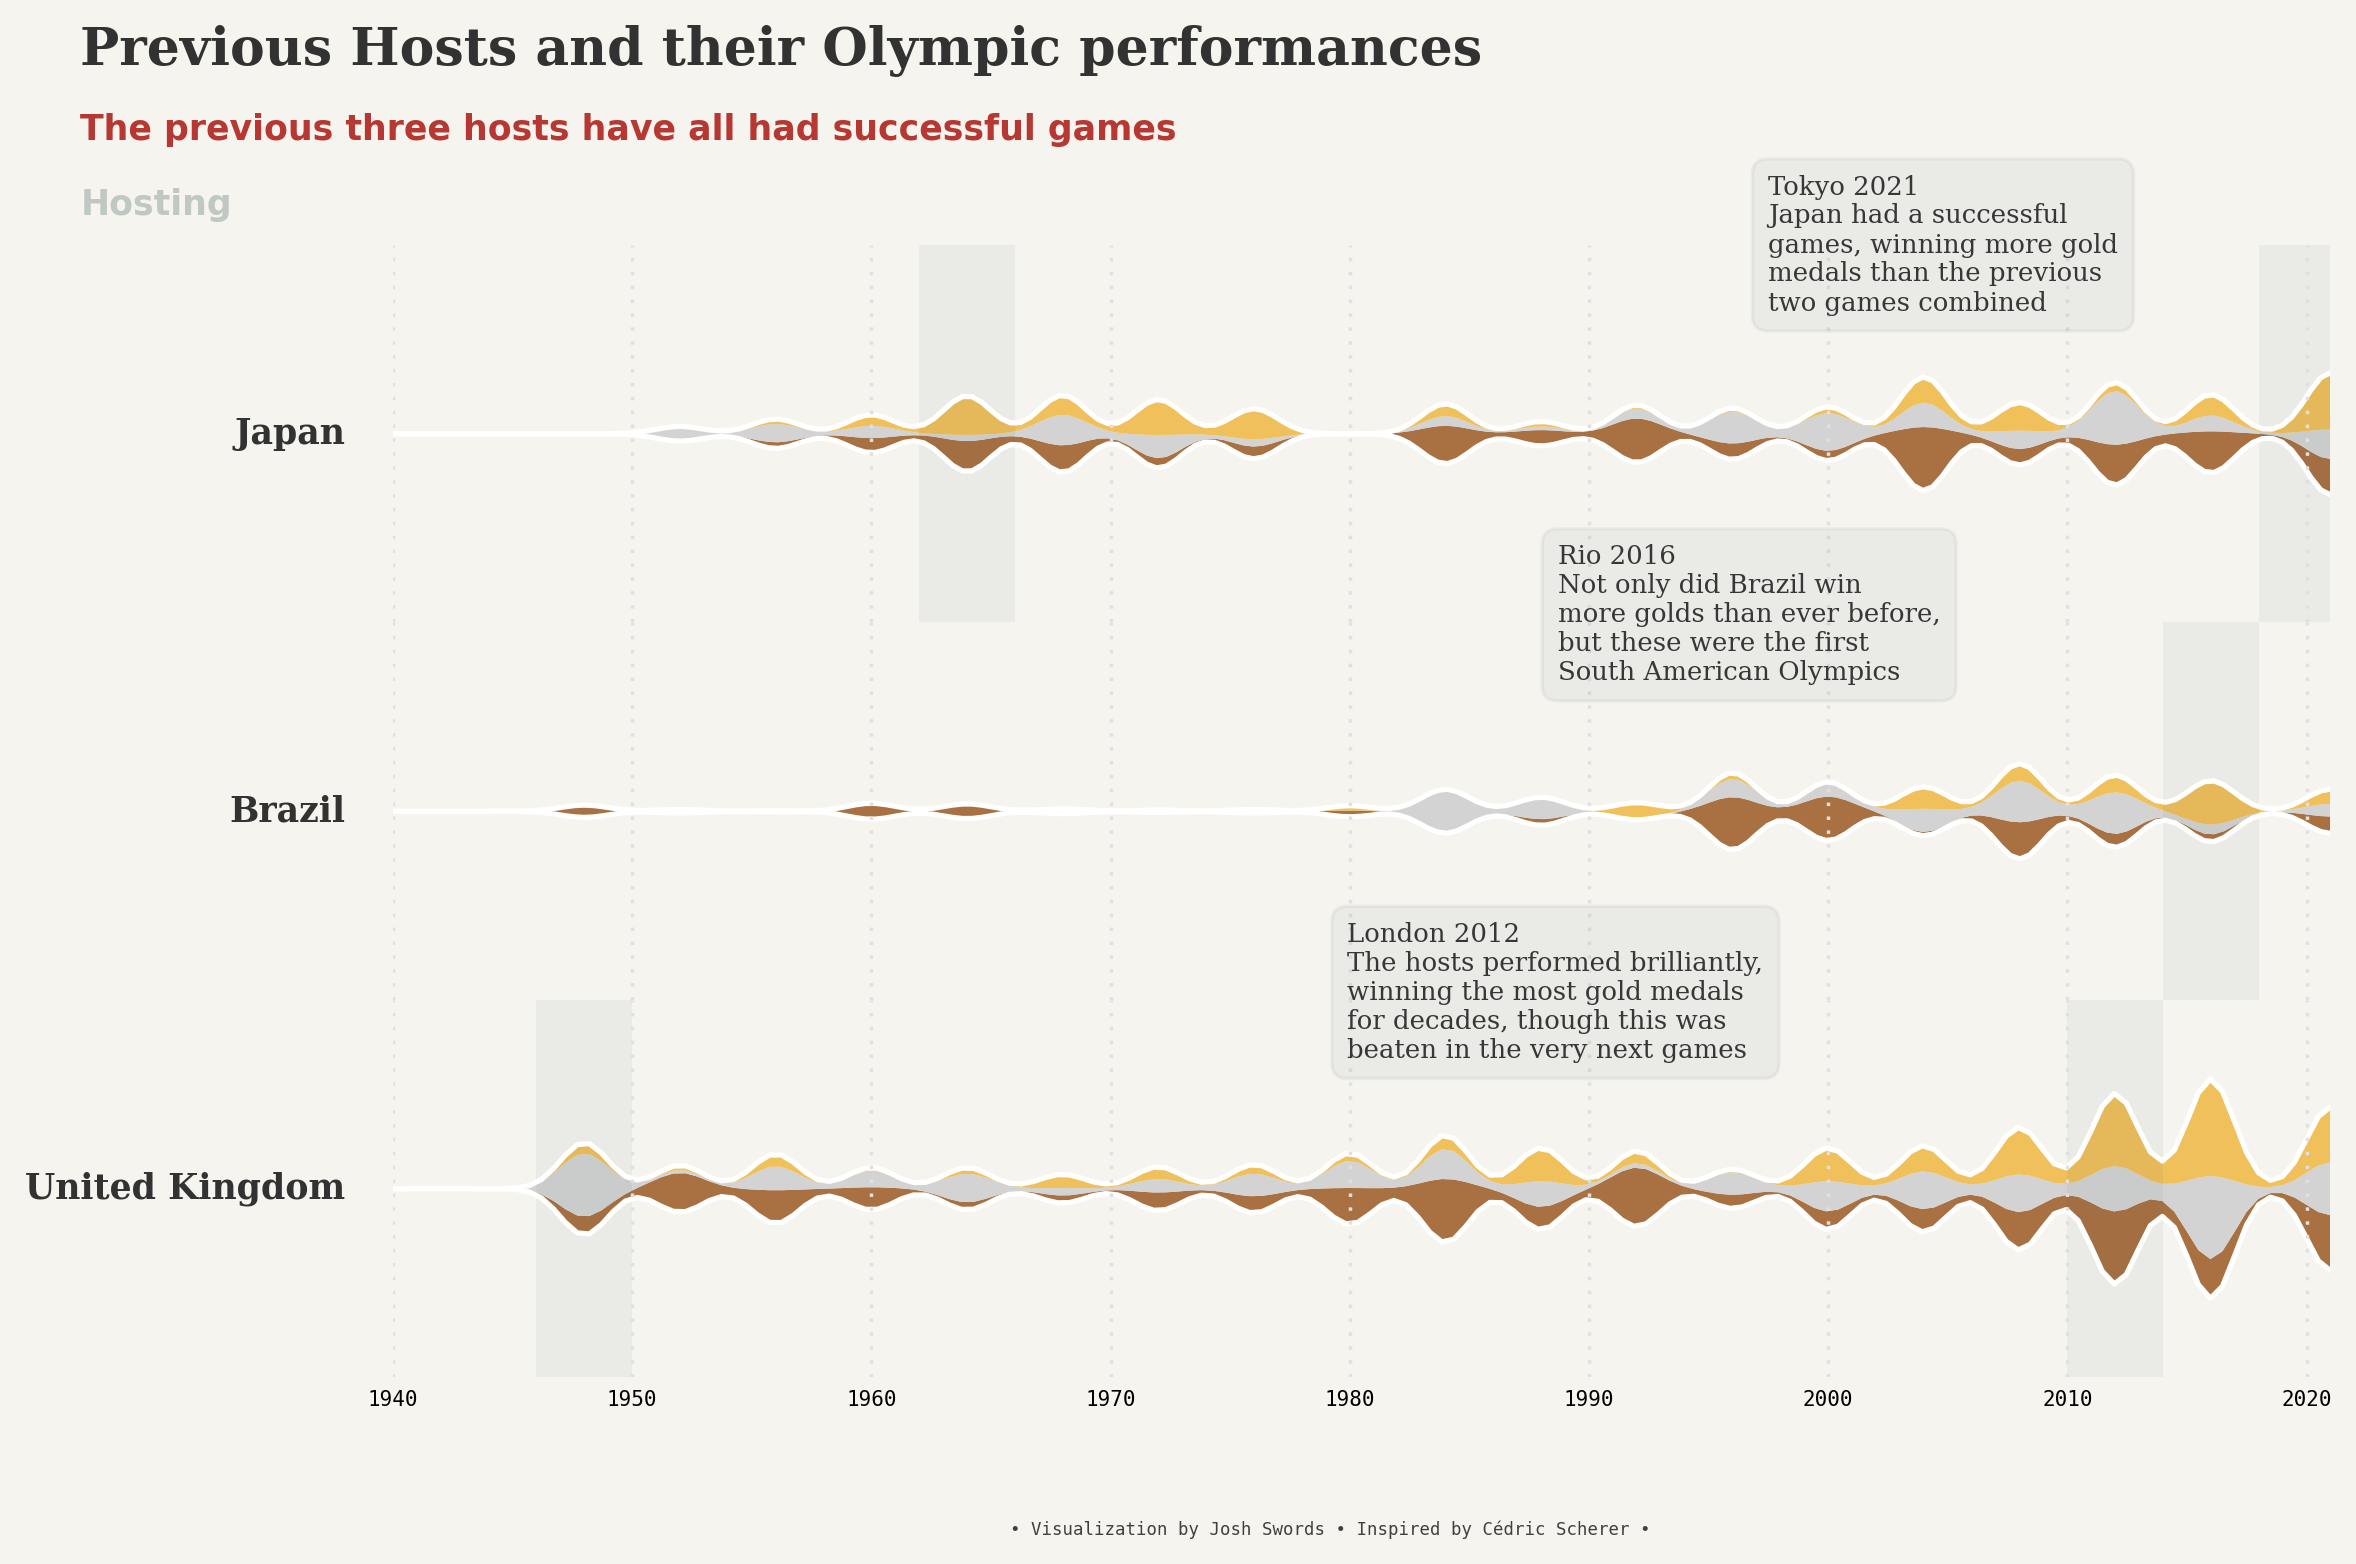

In [10]:
# Function for lightening colors
# https://www.python-graph-gallery.com/
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])
# Function for smoothing
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)


#Overall figure
fig, ax = plt.subplots(3,1, figsize=(10, 6),dpi=250, facecolor=background_color)


colors = ['#a97142', 'lightgray', '#f0c05a']

x_ticks = [1940,1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]

for axes, country in enumerate(['Japan', 'Brazil', 'United Kingdom']):
        # Define & transform data
        stream = df_new.query(f"region = ='{country}'")[['Year','Gold', 'Silver','Bronze']]
        y = [stream['Bronze'].values, stream['Silver'].values, stream['Gold'].values]
        x = np.array(df_new.query(f"region == '{country}'")['Year'])

        grid = np.linspace(x.min(), x.max(), num=250)
        y_smoothed = [gaussian_smooth(x, y_, grid, 1) for y_ in y]
        
        # Build plot
        ax[axes].stackplot(grid, y_smoothed, baseline="sym", colors=colors)

        line = np.array(y_smoothed).sum(0)
        ax[axes].plot(grid, line / 2, lw=1.5, color="white")
        ax[axes].plot(grid, -line / 2, lw=1.5, color="white")
        
        # Label
        ax[axes].text(1938,0,f'{country}',ha='right',va='center',fontfamily='serif',fontweight='bold',color='#323232')
        
        # Axes tweaks & visual changes
        ax[axes].set_ylim(-25, 25)
        ax[axes].set_xlim(1940, 2021)
        ax[axes].set_facecolor(background_color)
        ax[axes].spines[:].set_visible(False)
        ax[axes].yaxis.set_visible(False)
        ax[axes].tick_params(axis=u'both', which=u'both',length=0)
        for x_tick in x_ticks:
                ax[axes].axvline(x_tick, color='#e0e0e0', ls=(0, (1, 3)),lw=1, zorder=10)

for axes in range(0,2):
    ax[axes].xaxis.set_visible(False)

# Hosting Olympics shaded areas

ax[2].tick_params(axis='x', labelsize=6, color='#4d4d4d')
ax[2].set_xticks(x_ticks)
#ax[0].xaxis.tick_top()

ax[0].axvspan(2018,2022, facecolor='#244747',alpha=0.05)
ax[0].axvspan(1962,1966, facecolor='#244747',alpha=0.05)

ax[1].axvspan(2014,2018, facecolor='#244747',alpha=0.05)

ax[2].axvspan(2010,2014, facecolor='#244747',alpha=0.05)
ax[2].axvspan(1946,1950, facecolor='#244747',alpha=0.05)


# Title & Subtitle

fig.text(0,1,"Previous Hosts and their Olympic performances", fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
fig.text(0,0.95, 'The previous three hosts have all had successful games', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')
fig.text(0,0.9, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#244747',alpha=0.25)

##

# Additional Text annotations

TEXTS = [
    {
        "text": 'Tokyo 2021\nJapan had a successful\ngames, winning more gold\nmedals than the previous\ntwo games combined',
        "ax": 0,
        "x": 0.8,
        "y": 1,
        "color": adjust_lightness("#323232", 1.1)
    },

    {
        "text": 'Rio 2016\nNot only did Brazil win\nmore golds than ever before,\nbut these were the first\nSouth American Olympics',
        "ax": 1,
        "x": 0.7,
        "y": 1.02,
        "color": adjust_lightness("#323232", 1.1)
    },
    
        {
        "text": 'London 2012\nThe hosts performed brilliantly,\nwinning the most gold medals\nfor decades, though this was \nbeaten in the very next games',
        "ax": 2,
        "x": 0.6,
        "y": 1.02,
        "color": adjust_lightness("#323232", 1.1)
    }
]

for text_box in TEXTS:
    ax[text_box["ax"]].text(
        x = text_box["x"],
        y = text_box["y"],
        s = text_box["text"], 
        ha="center",
        va="center",
        ma="left",
        fontsize=7.5,fontfamily='serif',
        color=text_box["color"],
        bbox=dict(
            boxstyle="round", 
            facecolor='#244747',alpha=0.05,
            edgecolor=text_box["color"],
            pad=0.6
        ),
        # This transform means we pass (0, 1) coordinates to locate
        # the text block
        transform=ax[text_box["ax"]].transAxes,
        zorder=999
    )
    # This ensures the text is on top of everything
    fig.texts.append(ax[text_box["ax"]].texts.pop())
    
fig.text(0.5, 0.02, "• Visualization by Josh Swords • Inspired by Cédric Scherer •",color='#404040',fontsize=5,ha="center")

fig

##
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()
    

**Overall: Summer Olympics**

Now I'll widen my view. 

Here's how the leaderboard stacks up when we consider all Summer Olympic games.

In [11]:
medals = df.groupby(['region','Medal'])['Medal'].count().unstack().fillna(0).astype(int)

medals['Total'] = medals['Bronze'] + medals['Silver'] + medals['Gold']

medals = medals[['Bronze','Silver','Gold','Total']].sort_values(by='Total', ascending=False)

medals.iloc[:15].style.set_caption('Medals by Country: Summer Olympic Games [Top 15]')\
.bar(subset=['Gold'], color='#f0c05a')\
.bar(subset=['Silver'], color='Lightgray')\
.bar(subset=['Bronze'], color='#a97142')\
#.background_gradient(subset=['Total'], cmap='BuGn')

Medal,Bronze,Silver,Gold,Total
region,,,,
United States of America,1197,1333,2472,5002
Russia,994,974,1220,3188
Germany,1064,987,1075,3126
United Kingdom,620,729,636,1985
France,587,575,465,1627
Italy,454,474,518,1446
Australia,515,456,362,1333
Hungary,363,328,432,1123
Sweden,358,396,354,1108


In [12]:
host_list = list(df_new.query("Is_Host == 1")['Host_Country'].value_counts().index)

medals_temp = medals.reset_index()
medals_map = pd.merge(global_polygons, medals_temp, left_on='name',right_on='region')
medals_map['Hosted'] = np.where(medals_map['name'].isin(host_list),1,0)

Let us now view the distribution of medals on a map.

The darker the color, the more medals a country has won

In [13]:
def rd2(x):
    return round(x, 2)

Temp = medals_map

minimum, maximum = Temp["Total"].quantile([0.05, 0.95]).apply(rd2)
mean = round(Temp["Total"].mean(), 2)


colormap = branca.colormap.LinearColormap(
    colors=["#f2f0f7", "#cbc9e2", "#9e9ac8", "#756bb1", "#54278f"],
    index=Temp["Total"].quantile([0.25, 0.5, 0.85, 0.95]),
    vmin=minimum,
    vmax=maximum,
)

colormap.caption = "Total medals"

from folium.plugins import Search
from folium.plugins import HeatMap


m = folium.Map(location=(50,0),zoom_start=3)


def style_function(x):
    return {
        "fillColor": colormap(x["properties"]["Total"]),
        "color": "black",
        "weight": 2,
        "fillOpacity": 0.5,
    }


Map_Layer = folium.GeoJson(
    Temp,
    name="Medals",
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=["name","Total","Gold","Silver","Bronze"], aliases=["Country","Total Medals","Gold","Silver","Bronze"], localize=True
    ),
).add_to(m)


plugins.Search(Map_Layer,position='topleft',
                           search_zoom=5,placeholder="Search for a country",weight=3,
                           search_label='region',
                           geom_type='Polygon').add_to(m)


minimap = plugins.MiniMap()
m.add_child(minimap)
    
folium.LayerControl().add_to(m)
colormap.add_to(m)

m

Next, I want an overview of how each country performs; when they host the olympics, when they don't, and on average.

First, let's look at all nations over time

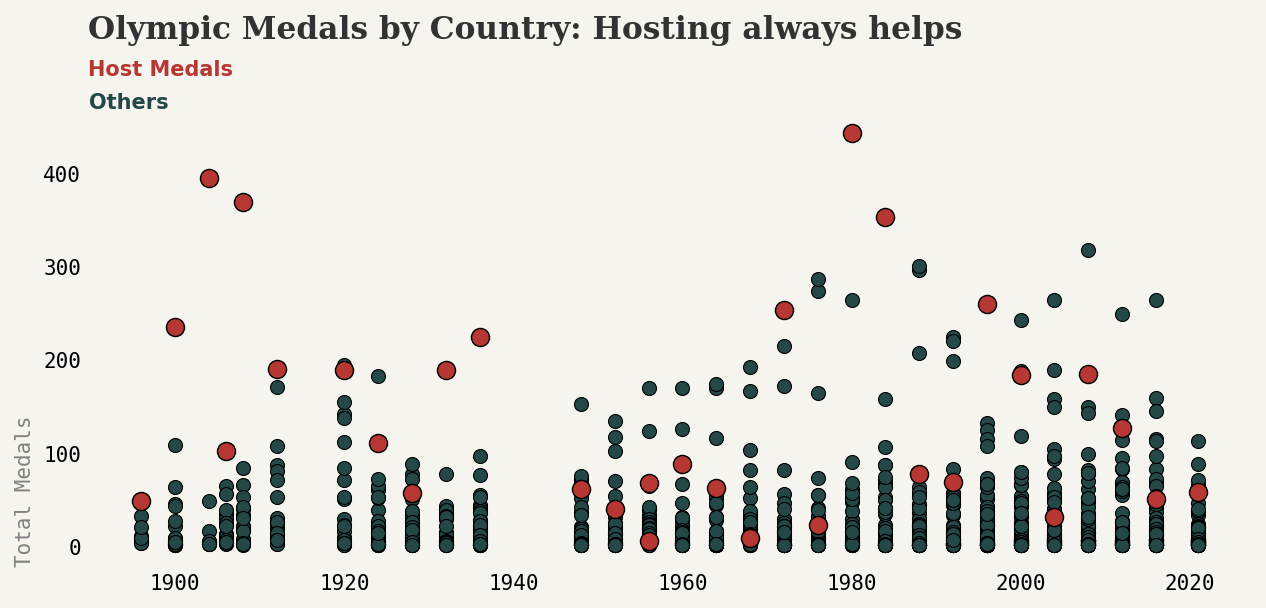

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,4), facecolor=background_color)

sns.scatterplot(data=df_new.query("Is_Host == 0"), x='Year', y='Total Medals', s=45, ec='black', color='#244747',ax=ax)
sns.scatterplot(data=df_new.query("Is_Host == 1"), x='Year', y='Total Medals', s=75, ec='black', color='#B73832',ax=ax)

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_ylabel("Total Medals",fontfamily='monospace',loc='bottom',color='gray')
ax.set_xlabel("")

ax.set_facecolor(background_color)
ax.set_axisbelow(True)


for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
    

ax.text(Xstart,Yend+80, 'Olympic Medals by Country: Hosting always helps', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart,Yend+40, 'Host Medals', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')
ax.text(Xstart,Yend+5, 'Others', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#244747')

plt.show()


**What does this show us?**

We see that host nations seem to attain higher medal totals than other nations.

However, we must view this with caution, as it's often the wealthy nations that host the games, therefore they are expected to do better anyway.

**Host Nations**

So we know that several nations seem to consistently perform well at the Olympic games. But that's not what this project is seeking to confirm.

It's now time to shift focus to those who have hosted the games.

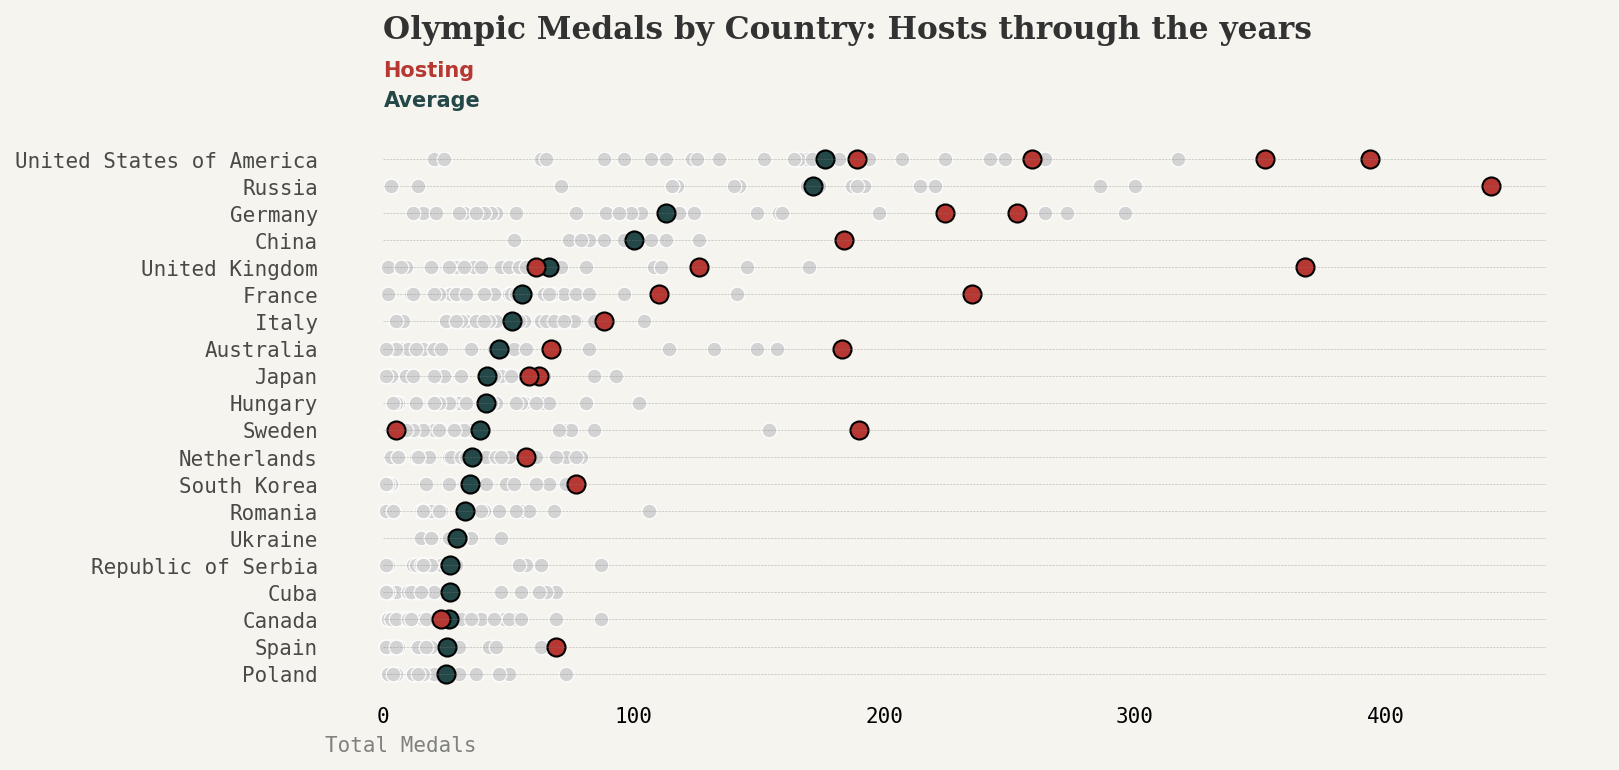

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11, 5), facecolor=background_color)

# top 20
top_list_ = df_new.groupby('region')['Total Medals'].mean().sort_values(ascending=False).reset_index()[:20].sort_values(by='Total Medals',ascending=True)

plot = 1
for country in top_list_['region']:
    mean = df_new[df_new['region'] == country].groupby('region')['Total Medals'].mean()
    # historic scores
    sns.scatterplot(data=df_new[df_new['region'] == country], y=plot, x='Total Medals',color='lightgray',s=50,ax=ax)
    # mean score
    sns.scatterplot(data=df_new[df_new['region'] == country], y=plot, x=mean,color='#244747',ec='black',linewidth=1,s=75,ax=ax)
    # Hosting score
    sns.scatterplot(data=(df_new[(df_new['region'] == country) & (df_new['Is_Host'] == 1)]), y=plot, x='Total Medals',color='#B73832',ec='black',linewidth=1,s=75,ax=ax)   
    plot += 1

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.set_yticks(top_list_.index+1)
ax.set_yticklabels(top_list_['region'][::-1], fontdict={'horizontalalignment': 'right'}, alpha=0.7)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel("Total Medals",fontfamily='monospace',loc='left',color='gray')
ax.set_facecolor(background_color)
ax.hlines(y=top_list_.index+1, xmin=0, xmax=Xend, color='gray', alpha=0.5, linewidth=.3, linestyles='--')
ax.set_axisbelow(True)


for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
    


ax.text(0,Yend+3.5, 'Olympic Medals by Country: Hosts through the years', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(0,Yend+2.1, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')
ax.text(0,Yend+1, 'Average', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#244747')


plt.show()

**What does this show us?**

This is a fantastic plot. I've focussed only on nations that have hosted the olympic games.

We gain so much information from just one visual. So, what do we see:

* Historic performance (grey dots)

* Average performance (blue dots)

* Performance when hosting (red dots)

It seems clear that when a nation hosts the olympics, they perform better!


**Let's view the host countries geographically**

In [16]:
Temp = medals_map

colormap = branca.colormap.LinearColormap(
    colors=["#f2f0f7",  "#B73832"],
    index=Temp["Hosted"].quantile([0.05, 0.5]),
    vmin=0,
    vmax=1,
)

colormap.caption = "Hosted"

from folium.plugins import Search
from folium.plugins import HeatMap


m = folium.Map(location=(50,0),zoom_start=3)


def style_function(x):
    return {
        "fillColor": colormap(x["properties"]["Hosted"]),
        "color": "black",
        "weight": 2,
        "fillOpacity": 0.5,
    }


Map_Layer = folium.GeoJson(
    Temp,
    name="Hosted",
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=["name","Total","Gold","Silver","Bronze"], aliases=["Country","Total Medals","Gold","Silver","Bronze"], localize=True
    ),
).add_to(m)


plugins.Search(Map_Layer,position='topleft',
                           search_zoom=5,placeholder="Search for a country",weight=3,
                           search_label='region',
                           geom_type='Polygon').add_to(m)


minimap = plugins.MiniMap()
m.add_child(minimap)
    
folium.LayerControl().add_to(m)
colormap.add_to(m)

m

**Does performance vary when hosting & not hosting?**

Let's take a sample from the new dataframe and plot the average medal totals for each nation, both when they've not hosted the olympics, and when they have.

In [17]:
sample = df_new.groupby(['region','Is_Host'])['Gold'].mean().unstack().dropna()
sample = sample.rename(columns={0 : "Not Hosting", 1 : "Hosting"})
sample = sample.reset_index().query("region == 'Japan' | region == 'Brazil' | region == 'United Kingdom' | region == 'China' | region == 'Greece' ").set_index('region')

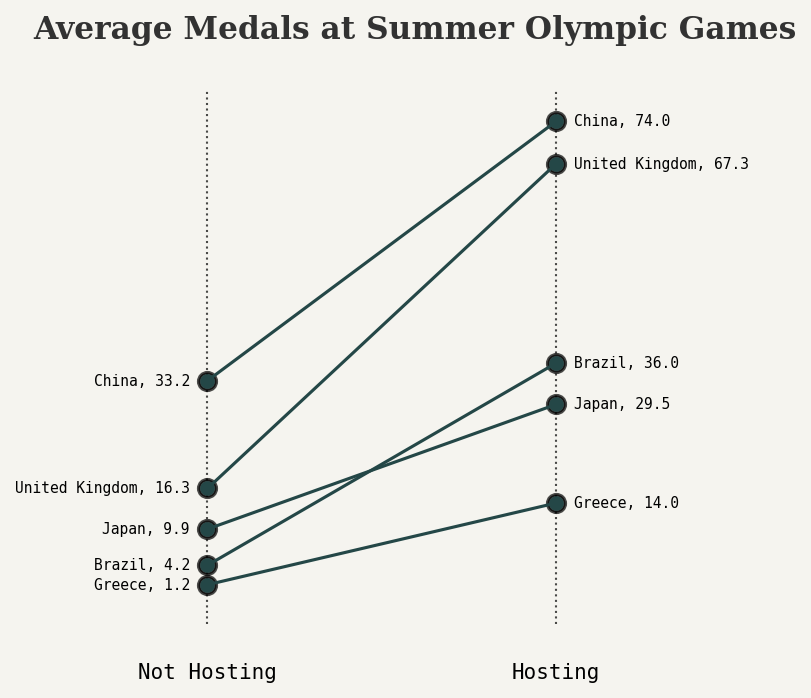

In [18]:
import matplotlib.lines as mlines

low_c = '#B73832'
high_c = '#244747'

left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(sample.index, sample['Not Hosting'])]
right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(sample.index, sample['Hosting'])]
klass = [low_c if (y1-y2) < 0 else high_c for y1, y2 in zip(sample['Not Hosting'], sample['Hosting'])]

# draw line
# https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color=low_c if p1[1]-p2[1] > 0 else high_c, marker='o', markersize=6)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(6,5), dpi= 150, facecolor=background_color)

ax.set_facecolor(background_color)
ax.vlines(x=1, ymin=-5, ymax=100, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=-5, ymax=100, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
ax.scatter(y=sample['Not Hosting'], x=np.repeat(1, sample.shape[0]), s=75,linewidth=1.5, color='black', alpha=0.7)
ax.scatter(y=sample['Hosting'], x=np.repeat(3, sample.shape[0]), s=75, linewidth=1.5,color='black', alpha=0.7)

# Line Segments and Annotation
for p1, p2, c in zip(sample['Not Hosting'], sample['Hosting'], sample.index):
    newline([1,p1], [3,p2])
    ax.text(1-0.1, p1, c + ', ' + str(round(p1,1)), horizontalalignment='right', verticalalignment='center', fontdict={'size':7})
    ax.text(3+0.1, p2, c + ', ' + str(round(p2,1)), horizontalalignment='left', verticalalignment='center', fontdict={'size':7})


ax.text(0,87,"Average Medals at Summer Olympic Games", fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')

ax.set(xlim=(0,4), ylim=(-10,sample.max().max()+5), ylabel='') #ylim=(), 
ax.set_xticks([1,3])
ax.set_xticklabels(["Not Hosting", "Hosting"],fontsize=10)
#ax.xaxis.tick_top()

for s in ["top","right","left","bottom"]:
    ax.spines[s].set_visible(False)
    
ax.tick_params(axis='both',which='both',length=0,labelleft=False) 
plt.rcParams["font.family"] = "monospace"

plt.show()

**What does this show us?**

This visual is very interesting.

We see that all but one nations **drastically imrproved their average total medal tally when they hosted an olympic games.**

Canada appear to be an anomaly - they performed much worse when they hosted.

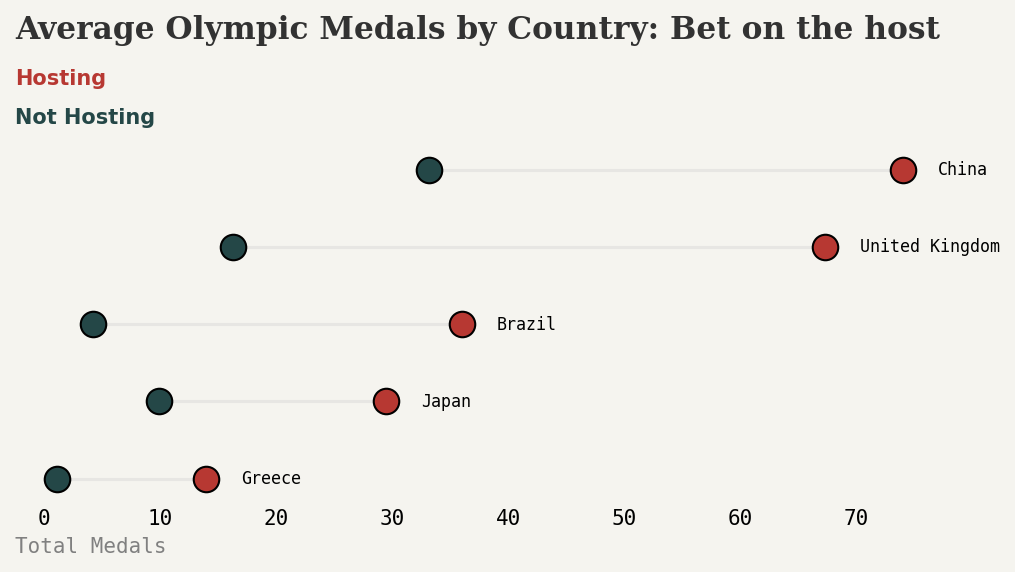

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,3), facecolor=background_color)

value1= sample['Not Hosting']
value2=sample['Hosting']


ordered_df = sample.sort_values(by='Hosting', ascending=True)
my_range=range(1,len(ordered_df.index)+1)
 

plt.hlines(y=my_range, xmin=ordered_df['Not Hosting'], xmax=ordered_df['Hosting'], color='lightgray', alpha=0.4,zorder=1)
plt.scatter(ordered_df['Not Hosting'], my_range, color='#244747', alpha=1, ec='black',label='Not Hosting',s=150)
plt.scatter(ordered_df['Hosting'], my_range, color='#B73832', alpha=1 , ec='black', label='Hosting',s=150)


for i in range(0,5):
    ax.annotate(ordered_df.index[i], 
                   xy=((ordered_df[["Not Hosting", "Hosting"]].max(axis=1)[i]+3),i+1), 
                   va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=8, color='black',rotation=0)


ax.axes.get_yaxis().set_ticks([])


for s in ['top','left', 'bottom', 'right']:
    ax.spines[s].set_visible(False)
    
ax.set_facecolor(background_color)    
ax.set_xlabel("Total Medals",fontfamily='monospace',loc='left',color='gray')
ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 
ax.set_yticklabels([])
    
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()


ax.text(Xstart,Yend+1.5, 'Average Olympic Medals by Country: Bet on the host', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart,Yend+0.9, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')
ax.text(Xstart,Yend+0.4, 'Not Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#244747')


plt.show()

**Medal Performance Over Time for Host Nations**

We've looked at static averages, but now let's view the games as they happened.

First, we can view the USA's medal tally over time. I'll highlight the games that they hosted.

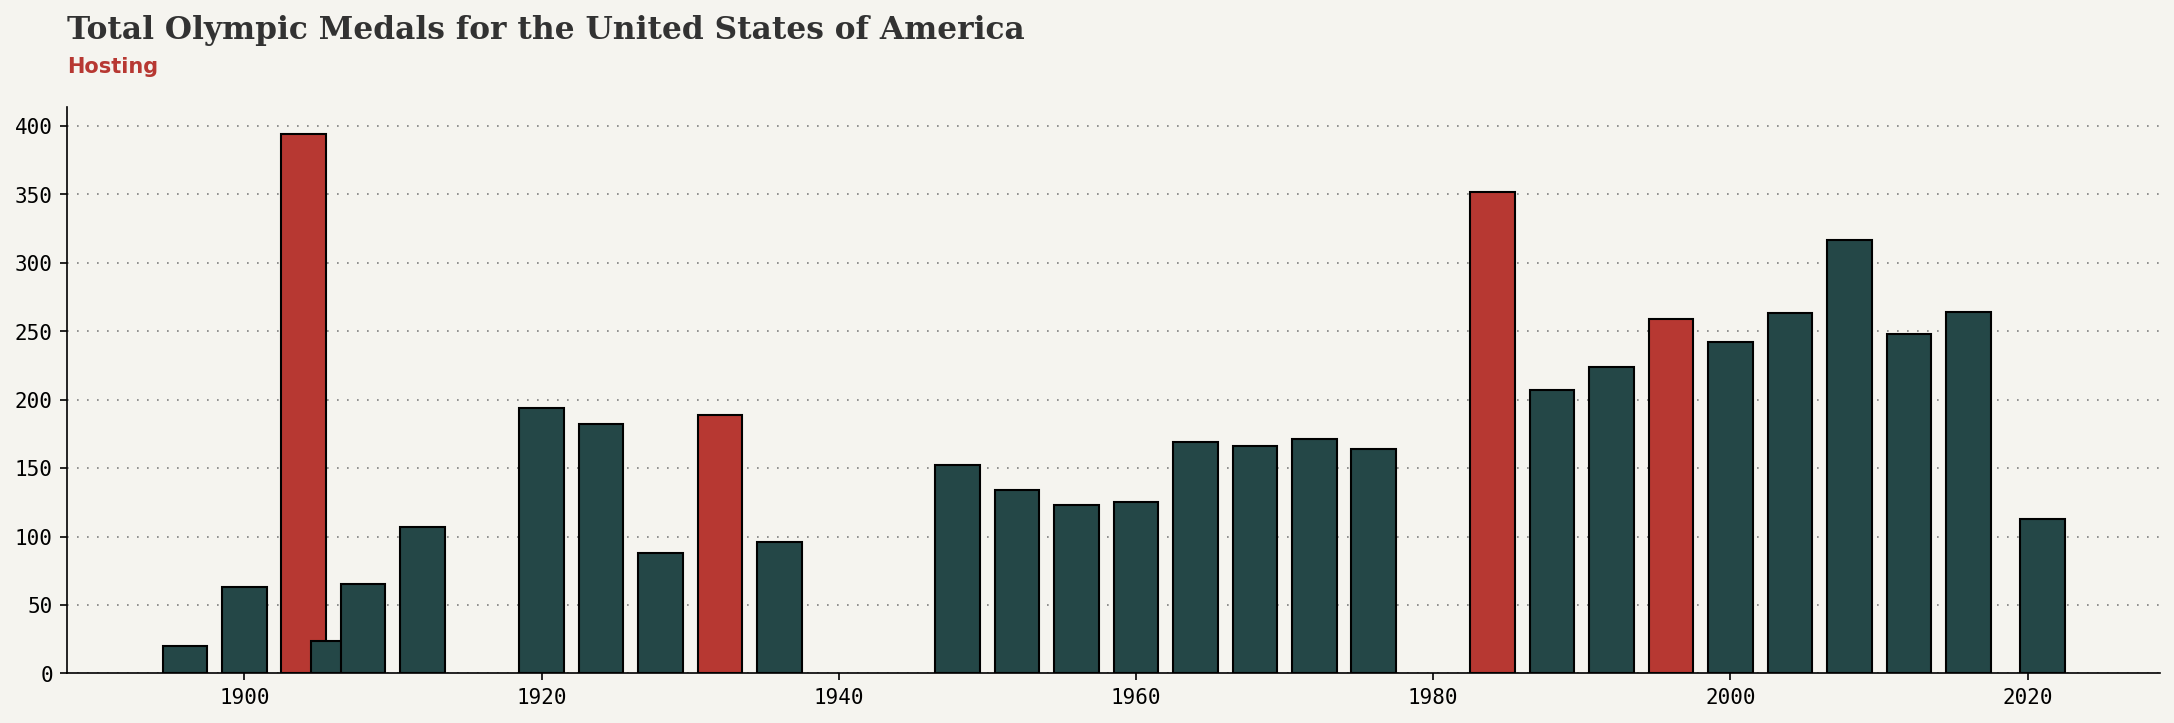

In [20]:
temp = df_new.query("region == 'United States of America'")


fig, ax = plt.subplots(1, 1, figsize=(18, 5), facecolor=background_color)

color = ['#B73832' if i == 1 else '#244747' for i in temp['Is_Host']]

ax.bar(temp['Year'], temp['Total Medals'],width=3, color=color, ec='black')
ax.set_facecolor(background_color)
ax.grid(which='both', axis='y', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart,Yend+50, 'Total Olympic Medals for the United States of America', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart,Yend+25, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')

plt.show()

**What does this show us?**

Depsite consistently performing well, it does look as though the USA performs even better when they are the tournament hosts.

What about other nations. Let's try the UK

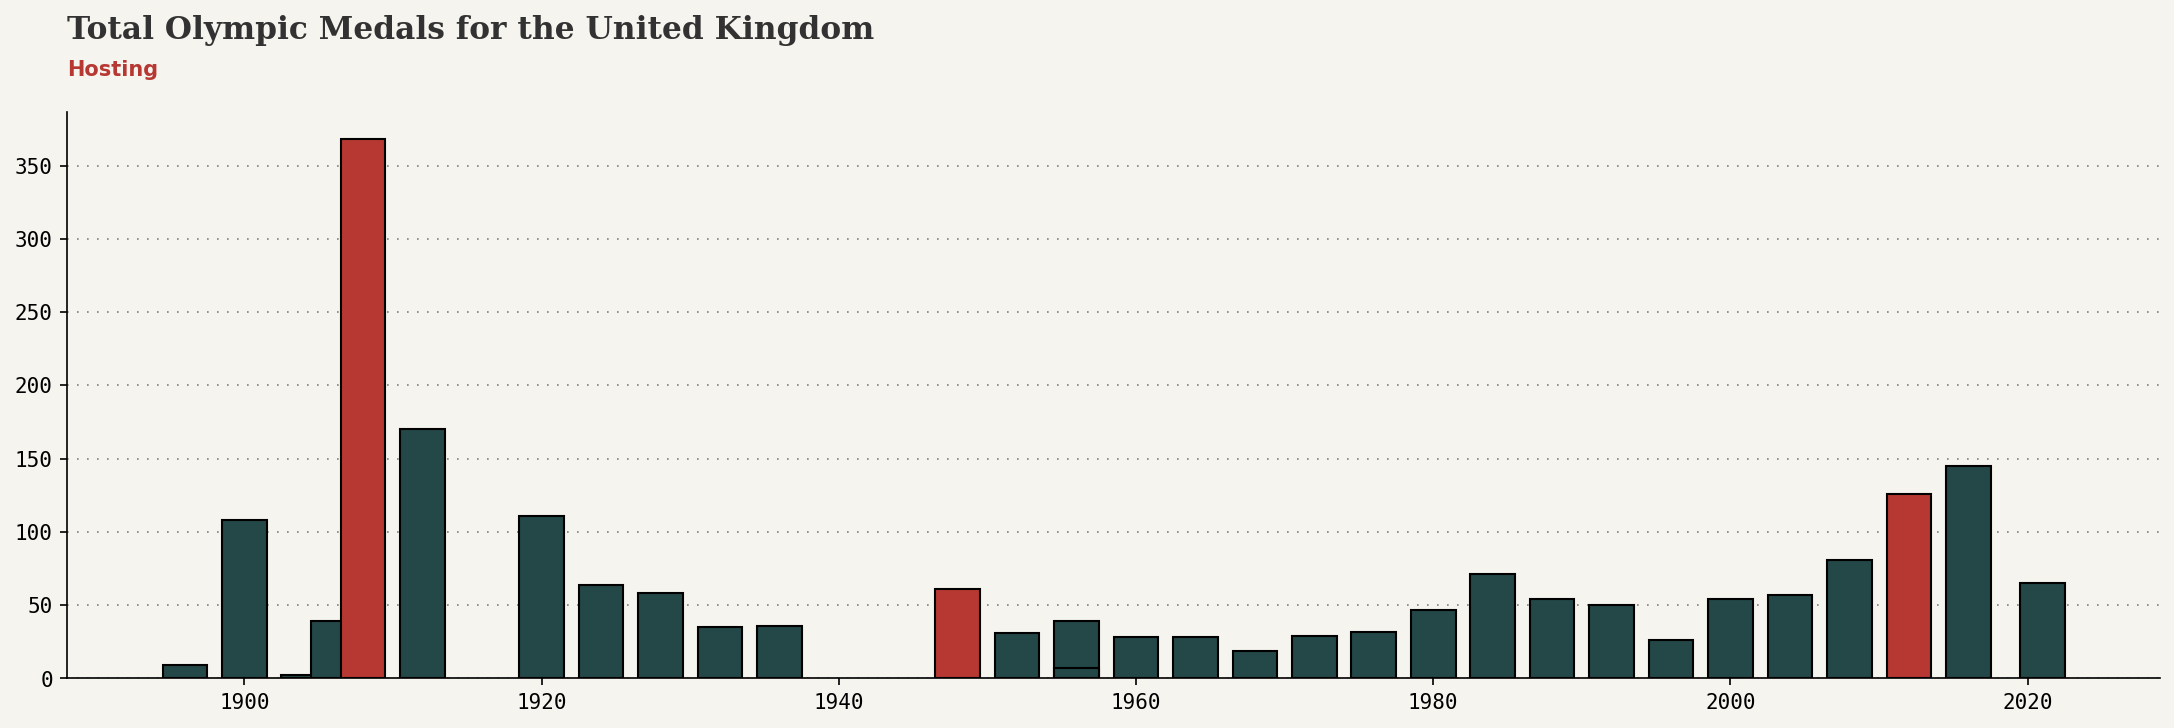

In [21]:
temp = df_new.query("region == 'United Kingdom'")


fig, ax = plt.subplots(1, 1, figsize=(18, 5), dpi=150, facecolor=background_color)

color = ['#B73832' if i == 1 else '#244747' for i in temp['Is_Host']]

ax.bar(temp['Year'], temp['Total Medals'],width=3, color=color, ec='black')
ax.set_facecolor(background_color)
ax.grid(which='both', axis='y', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart,Yend+50, 'Total Olympic Medals for the United Kingdom', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart,Yend+25, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')

plt.show()

**What does this show us?**

Again, it appears that hosting does help performance.

However, the UK was on an upward trend during the 2000's, so perhaps this would have continued anyway

**What about Gold medals?**

I've focussed on Total Medals so far, as I beleive all medals are impressive. 

However, we can view each separately...

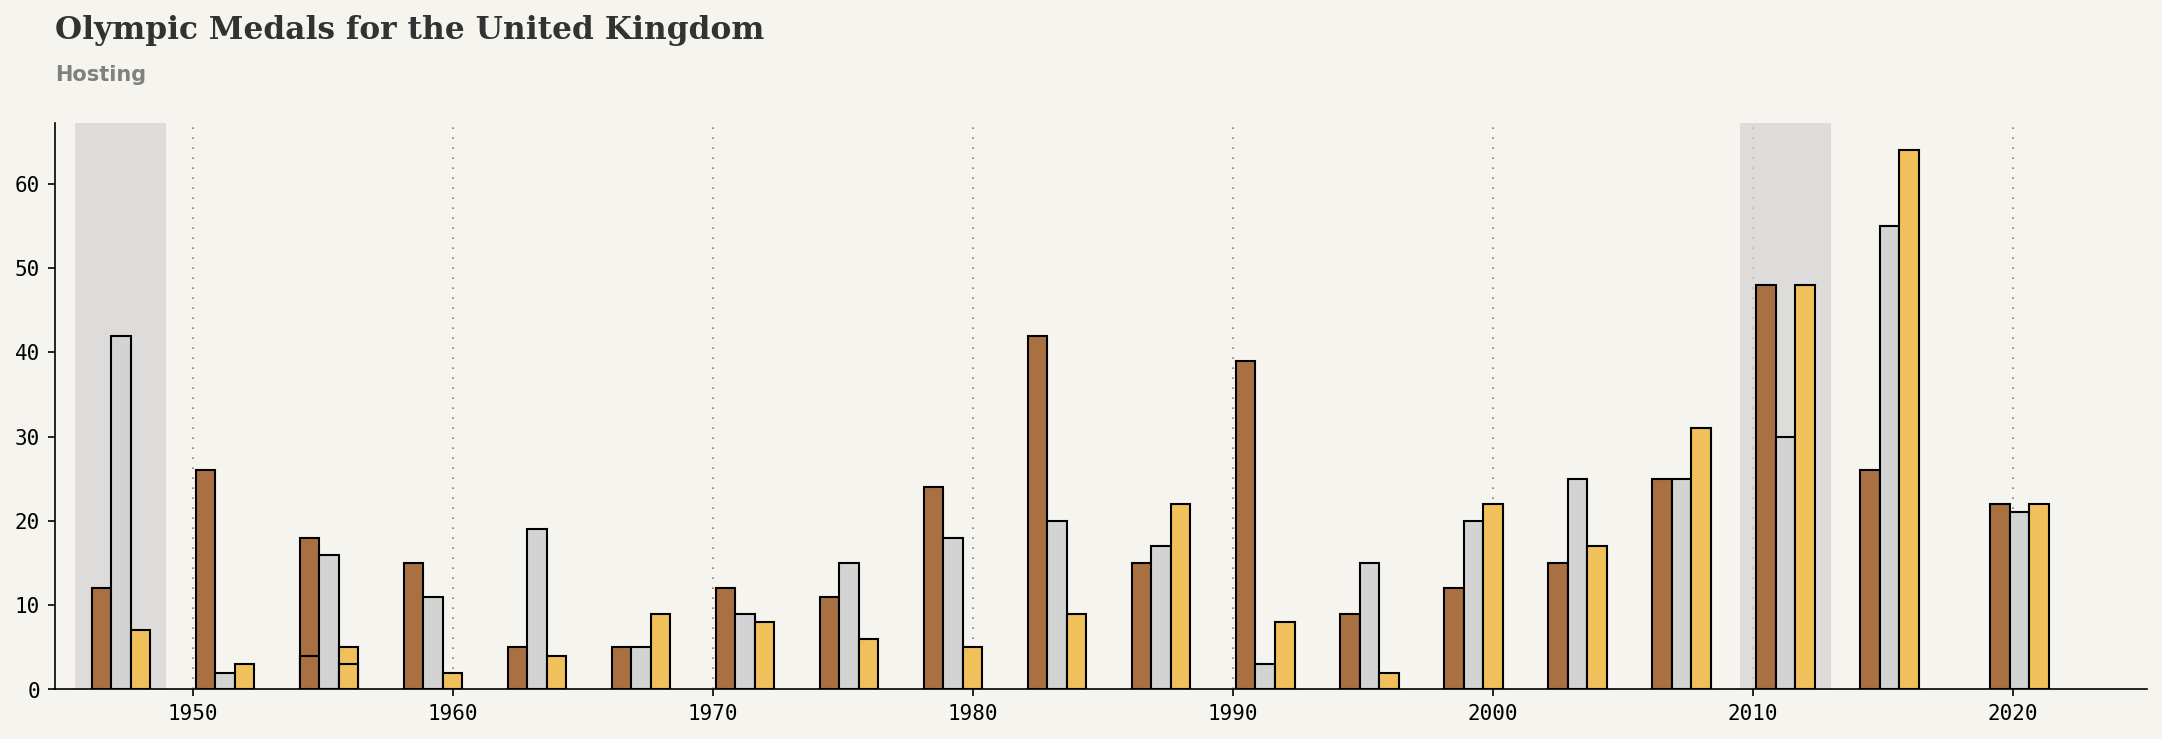

In [22]:
temp = df_new.query("region == 'United Kingdom' & Year > 1945")

fig, ax = plt.subplots(1, 1, figsize=(18, 5), facecolor=background_color)

ax.set_facecolor(background_color)

color = ["#a97142", "lightgray", '#f0c05a']


# Host years
ax.axvspan(1949,1945.5, facecolor='lightgray',alpha=0.7)
ax.axvspan(2013,2009.5, facecolor='lightgray',alpha=0.7)

medals_list = ['Bronze', 'Silver', 'Gold']
width = 0.75
for i, medal in enumerate(np.array(medals_list)):
    ax.bar(temp['Year']+(width*(i-2)), temp[medal], width, color=color[i], label=medal, ec='black')
    
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart+3,Yend+10, 'Olympic Medals for the United Kingdom', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart+3,Yend+5, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='gray')


ax.set_xlim(Xstart+3, Xend)

ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))

ax.set_axisbelow(True)

plt.show()

**What does this show us?**

The UK, when hosting in 2012, had a great performance, with the highest number of gold medals ever. This was then surpassed in Rio 2016 though.

**Proportions**

Let's move away from totals, and towards proportions

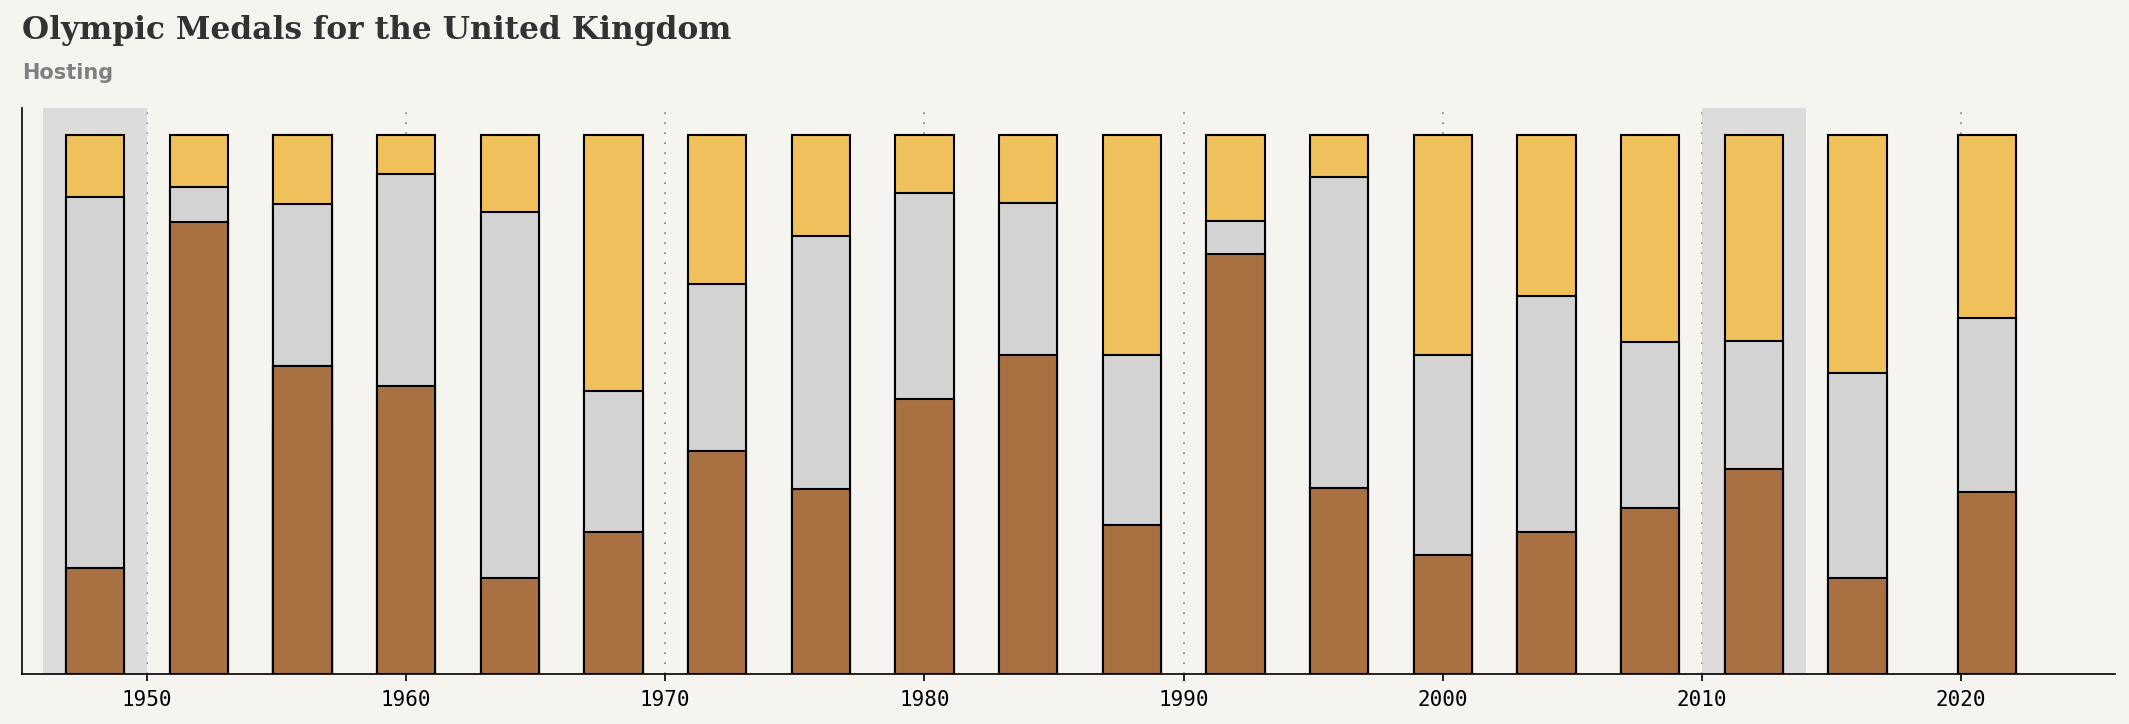

In [23]:
stack_temp = df_new.query("region == 'United Kingdom' & Year > 1945")[['Year','Bronze','Silver','Gold']].set_index('Year')
stack_temp = (stack_temp.T/stack_temp.sum(axis=1)).cumsum().T

fig, ax = plt.subplots(1,1, figsize=(18,5), facecolor=background_color)

# Host years
ax.axvspan(1950,1946, facecolor='lightgray',alpha=0.7)
ax.axvspan(2014,2010, facecolor='lightgray',alpha=0.7)


color = ["#a97142", "lightgray", '#f0c05a']
medals_list = ['Bronze', 'Silver', 'Gold']

for i, medal in enumerate(medals_list[::-1]):
    sentims = stack_temp[medal]
    ax.bar(sentims.index, sentims, color=color[::-1][i], label=medal, width=2.25, ec='black')

ax.set_facecolor(background_color)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.set_xlim(Xstart+3, Xend)
ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)
ax.get_yaxis().set_visible(False)

ax.text(Xstart+3,Yend+0.13, 'Olympic Medals for the United Kingdom', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart+3,Yend+0.055, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='gray')


plt.show()

**What does this show us?**

As mentioned previously, hosting does appear to have a positive effect on total medals, but this looks to be true of gold medals too.

**What about Japan?**

As I mentioned at the beginning, I was impressed by Japan at this olympics. Did they perform better than usual?

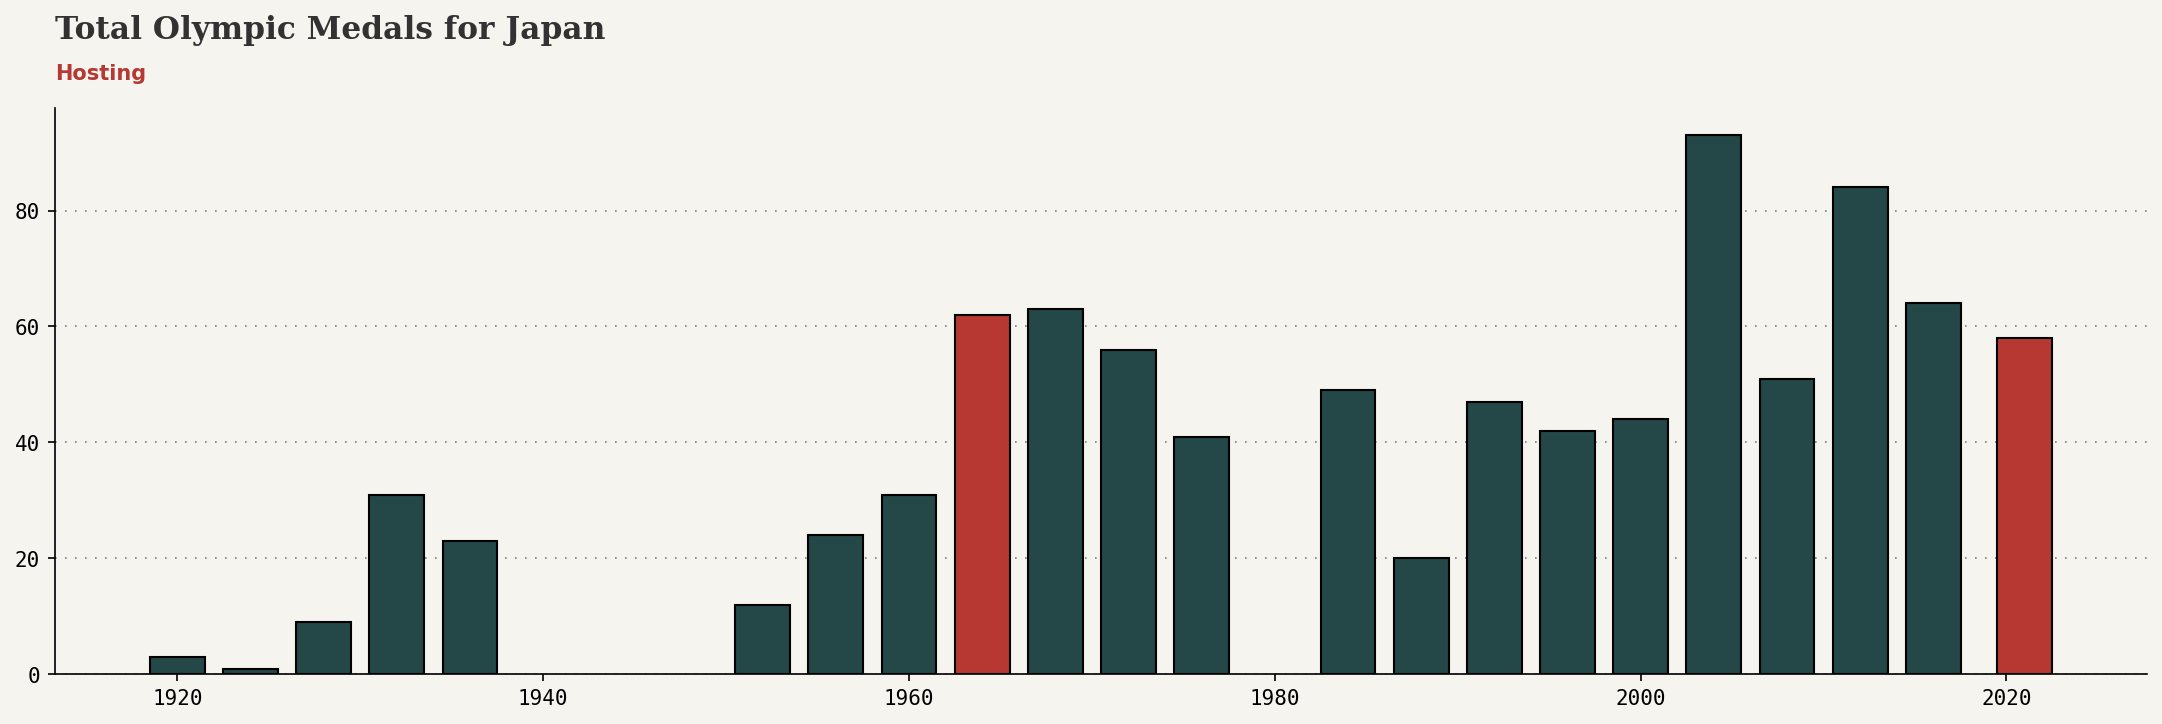

In [24]:
temp = df_new.query("region == 'Japan'")


fig, ax = plt.subplots(1, 1, figsize=(18, 5), dpi=150, facecolor=background_color)

color = ['#B73832' if i == 1 else '#244747' for i in temp['Is_Host']]

ax.bar(temp['Year'], temp['Total Medals'],width=3, color=color, ec='black')
ax.set_facecolor(background_color)
ax.grid(which='both', axis='y', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart,Yend+12, 'Total Olympic Medals for Japan', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart,Yend+5, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')

plt.show()

Interestingly, Japan's total medal count is not too extraordinary compared to previous olympics. Though it is still impressive, in Japan's last 5 olympic appearances it would rank 4th.

What about gold medals? This is, afterall, how the medal table it often calculated

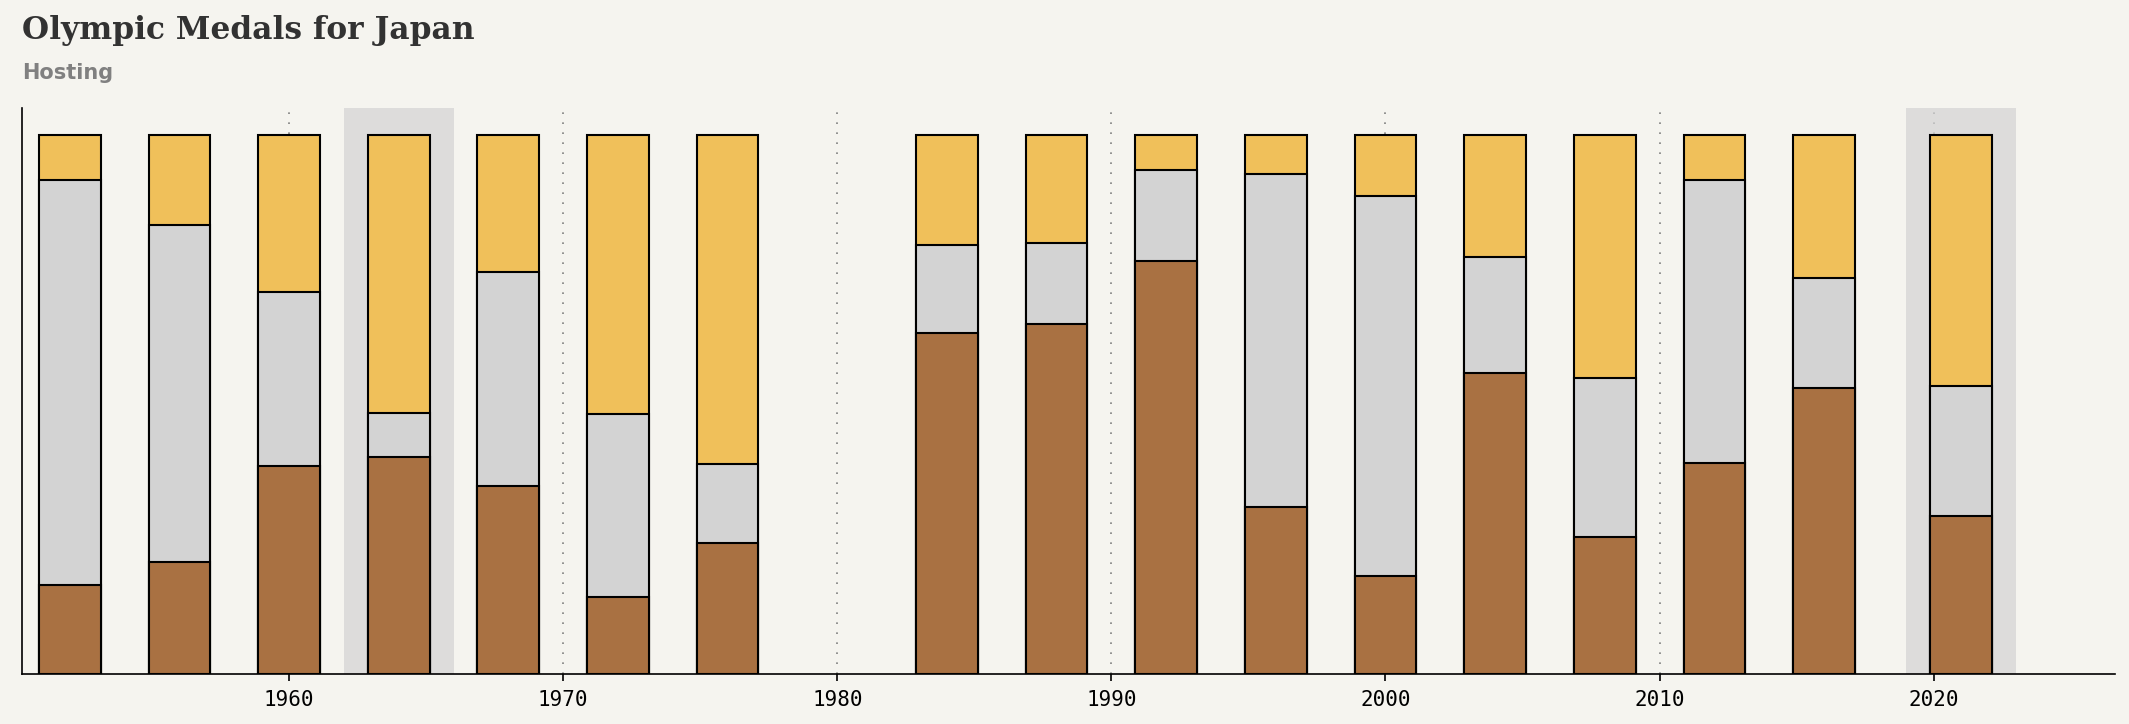

In [25]:
stack_temp = df_new.query("region == 'Japan' & Year > 1945")[['Year','Bronze','Silver','Gold']].set_index('Year')
stack_temp = (stack_temp.T/stack_temp.sum(axis=1)).cumsum().T

fig, ax = plt.subplots(1,1, figsize=(18,5), facecolor=background_color)

# Host years
ax.axvspan(2023,2019, facecolor='lightgray',alpha=0.7)
ax.axvspan(1966,1962, facecolor='lightgray',alpha=0.7)


color = ["#a97142", "lightgray", '#f0c05a']
medals_list = ['Bronze', 'Silver', 'Gold']

for i, medal in enumerate(medals_list[::-1]):
    sentims = stack_temp[medal]
    ax.bar(sentims.index, sentims, color=color[::-1][i], label=medal, width=2.25, ec='black')

ax.set_facecolor(background_color)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.set_xlim(Xstart+3, Xend)

ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))

ax.set_axisbelow(True)
ax.get_yaxis().set_visible(False)

ax.text(Xstart+3,Yend+0.13, 'Olympic Medals for Japan', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart+3,Yend+0.055, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='gray')

plt.show()

**What does this show us?**

Japan, hosts for 2020 (2021), had a fantastic games in terms of gold medals; winning the highest proportion of golds for over 40 years.

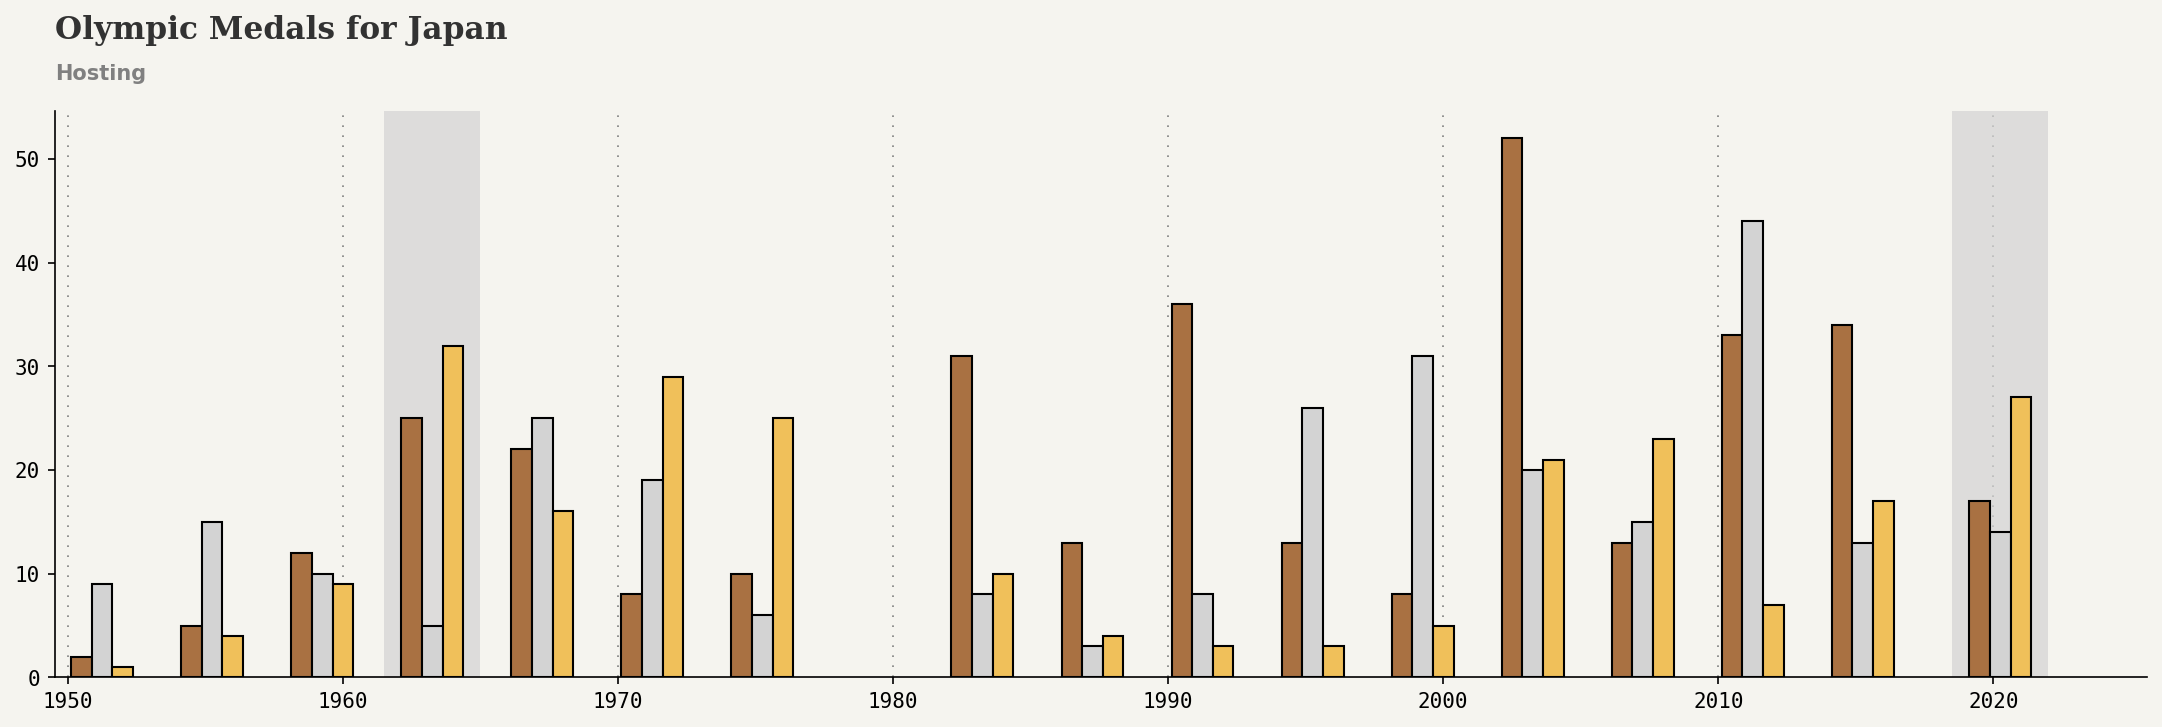

In [26]:
temp = df_new.query("region == 'Japan' & Year > 1945")

fig, ax = plt.subplots(1, 1, figsize=(18, 5), facecolor=background_color)

ax.set_facecolor(background_color)

color = ["#a97142", "lightgray", '#f0c05a']


# Host years
ax.axvspan(2022,2018.5, facecolor='lightgray',alpha=0.7)
ax.axvspan(1965,1961.5, facecolor='lightgray',alpha=0.7)

medals_list = ['Bronze', 'Silver', 'Gold']
width = 0.75
for i, medal in enumerate(np.array(medals_list)):
    ax.bar(temp['Year']+(width*(i-2)), temp[medal], width, color=color[i], ec='black')
    

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart+3,Yend+7, 'Olympic Medals for Japan', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart+3,Yend+3, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='gray')

ax.set_xlim(Xstart+3, Xend)
ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

plt.show()

**What does this show us?**

Not only is the proportion of gold medals higher than usual, so too is the absolute number. This was also the case when Japan hosted the games back in the 60's, too. We can view this more clearly below

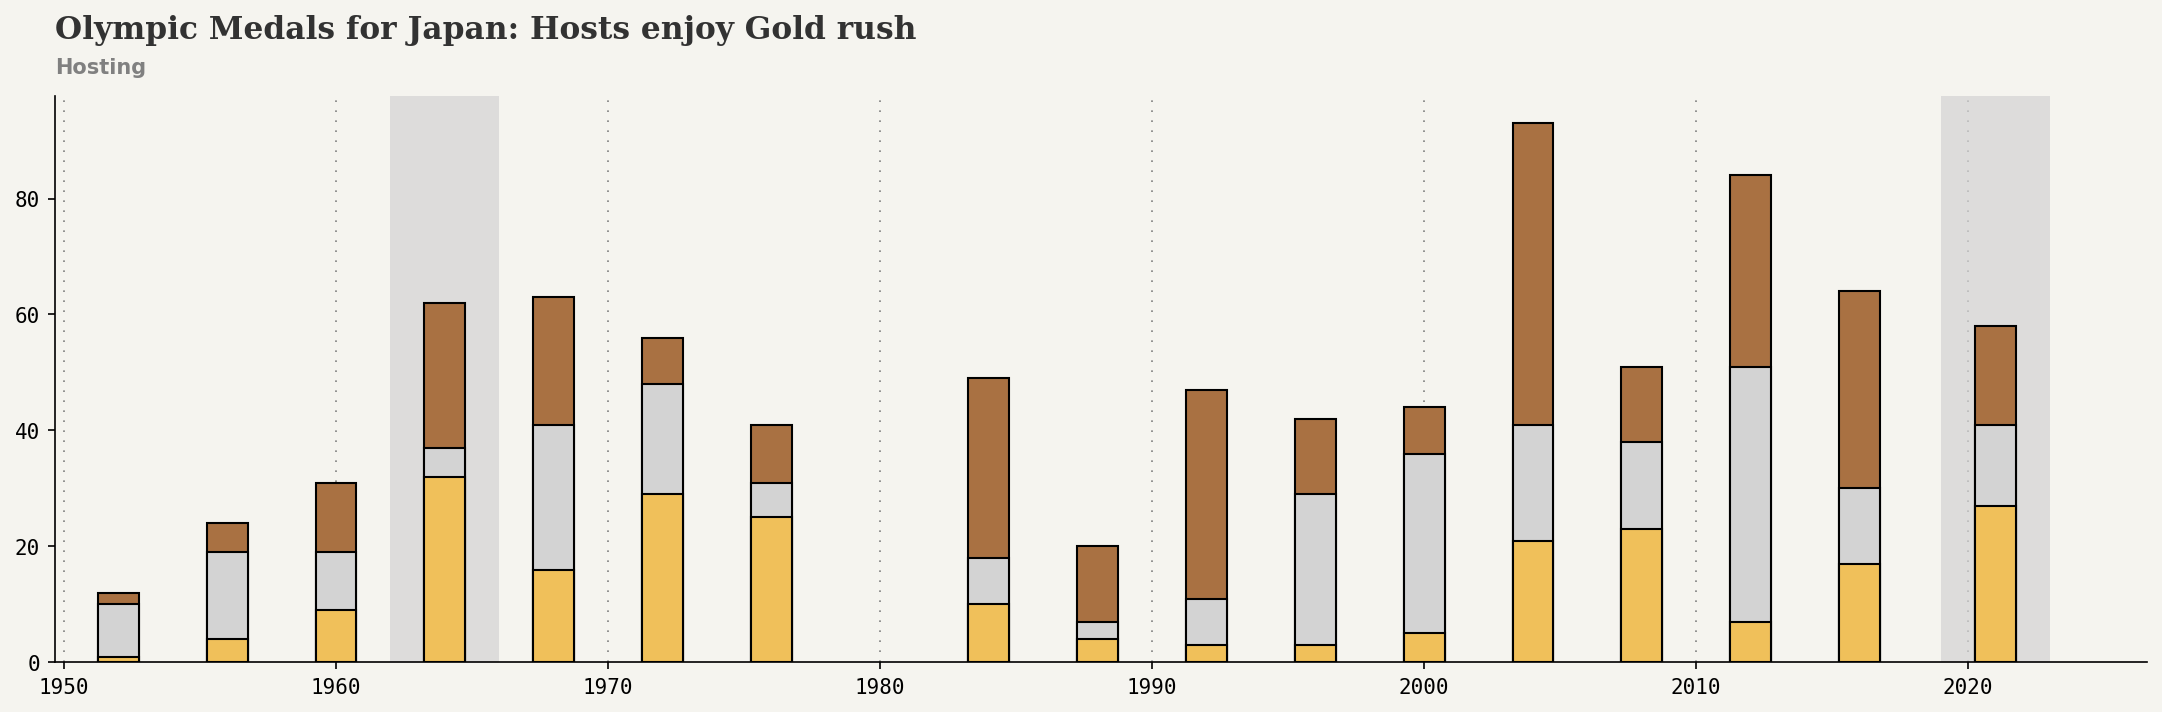

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5), facecolor=background_color)

ax.set_facecolor(background_color)

color = ["#a97142", "lightgray", '#f0c05a']

# Host years
ax.axvspan(2023,2019, facecolor='lightgray',alpha=0.7)
ax.axvspan(1966,1962, facecolor='lightgray',alpha=0.7)


for i, medal in enumerate(medals_list):
    temp = df_new.query("region == 'Japan' & Year > 1945").groupby(['Year'])['Gold','Silver','Bronze'].sum().cumsum(axis=1)[medal]
    ax.bar(temp.index, temp, color=color[i],width=1.5,ec='black')
    

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart+2,Yend+10, 'Olympic Medals for Japan: Hosts enjoy Gold rush', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart+2,Yend+4, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='gray')

ax.set_xlim(Xstart+2, Xend)
ax.grid(which='both', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))
ax.set_axisbelow(True)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
plt.show()

# **Statistical Testing**

We have seen through our visual journey that Hosting thw Olympics does seem to lead to an increased performance, but we will now do some statistical tests to find out whether or not these differences could be considered significant or not.

In [28]:
host_list = list(df_new.query("Is_Host == 1")['Host_Country'].value_counts().index)

Not_hosting = df_new[df_new['region'].isin(host_list)].query("Is_Host == 0")[['Bronze','Silver','Gold']].mean().reset_index()
hosting = df_new[df_new['region'].isin(host_list)].query("Is_Host == 1")[['Bronze','Silver','Gold']].mean().reset_index()

radar = pd.merge(hosting, Not_hosting, on='index')
radar.columns = ['Medal','Hosting', 'Not Hosting']
radar = radar.set_index('Medal').T.reset_index()
radar = radar[['index','Gold','Silver','Bronze']]

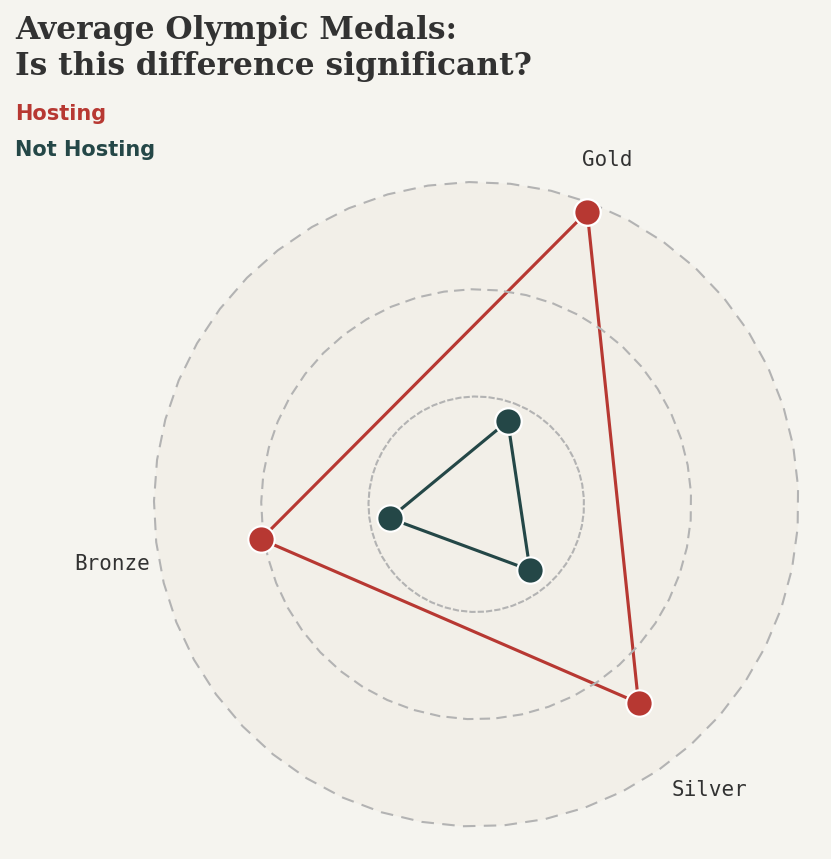

In [29]:
# Inpsired by Tuo Wang, https://tuowang.rbind.io/
# https://www.python-graph-gallery.com/
# Host or Not Host
Comparison = radar["index"].values.tolist()

medals = ['Gold', 'Silver','Bronze']
length = len(medals)

colors = ["#B73832", "#244747"]

# The angles at which the values of the numeric variables are placed
ANGLES = [n / length * 2 * np.pi for n in range(length)]
ANGLES += ANGLES[:1]
 
# Angle values going from 0 to 2*pi
HANGLES = np.linspace(0, 2 * np.pi)

# Surrounding circles
H0 = np.ones(len(HANGLES)) * 20
H1 = np.ones(len(HANGLES)) * 40
H2 = np.ones(len(HANGLES)) * 60

# Plot
fig = plt.figure(figsize=(6, 6), facecolor=background_color)
ax = fig.add_subplot(1,1,1, polar=True)
ax.set_facecolor(background_color)
 
# rotate plot
ax.set_theta_offset(np.pi / 2.6)
ax.set_theta_direction(-1)

# Radius of plot
ax.set_ylim(-0.1, radar[['Gold','Silver','Bronze']].max().max()+5)

# Radar
for idx, host in enumerate(Comparison):
    values = radar.iloc[idx].drop("index").values.tolist()
    values += values[:1]
    ax.plot(ANGLES, values, c=colors[idx], linewidth=1.5, label=host)
    ax.scatter(ANGLES, values, s=160, c=colors[idx],ec='white',zorder=10)

# edit lines & fill between
ax.plot(HANGLES, H0, ls=(0, (3, 1)),lw=1, c='#b3b3b3')
ax.plot(HANGLES, H1, ls=(0, (5, 3)),lw=1, c='#b3b3b3')
ax.plot(HANGLES, H2, ls=(0, (6, 4)),lw=1, c='#b3b3b3')
ax.fill(HANGLES, H2, '#f2efe8')

# Tidy up & labels
ax.set_xticks(ANGLES[:-1])
ax.set_xticklabels(medals, size=10, color='#323232')
ax.set_yticks([])
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.spines["start"].set_color("none")
ax.spines["polar"].set_color("none")

# Title
fig.text(0,0.98, 'Average Olympic Medals:\nIs this difference significant?', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
fig.text(0,0.93, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')
fig.text(0,0.89, 'Not Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#244747')

plt.show()

**What does this show us?**

This shows what we've seen throughout this analysis.

Using only countries who have hosted an olympic games, what is their average medal tally when Hosting & Not Hosting. It is clear that Hosting provides the higher tally, but contries host very infrequently, therefore, we must conduct statistical tests to be sure of this intuition

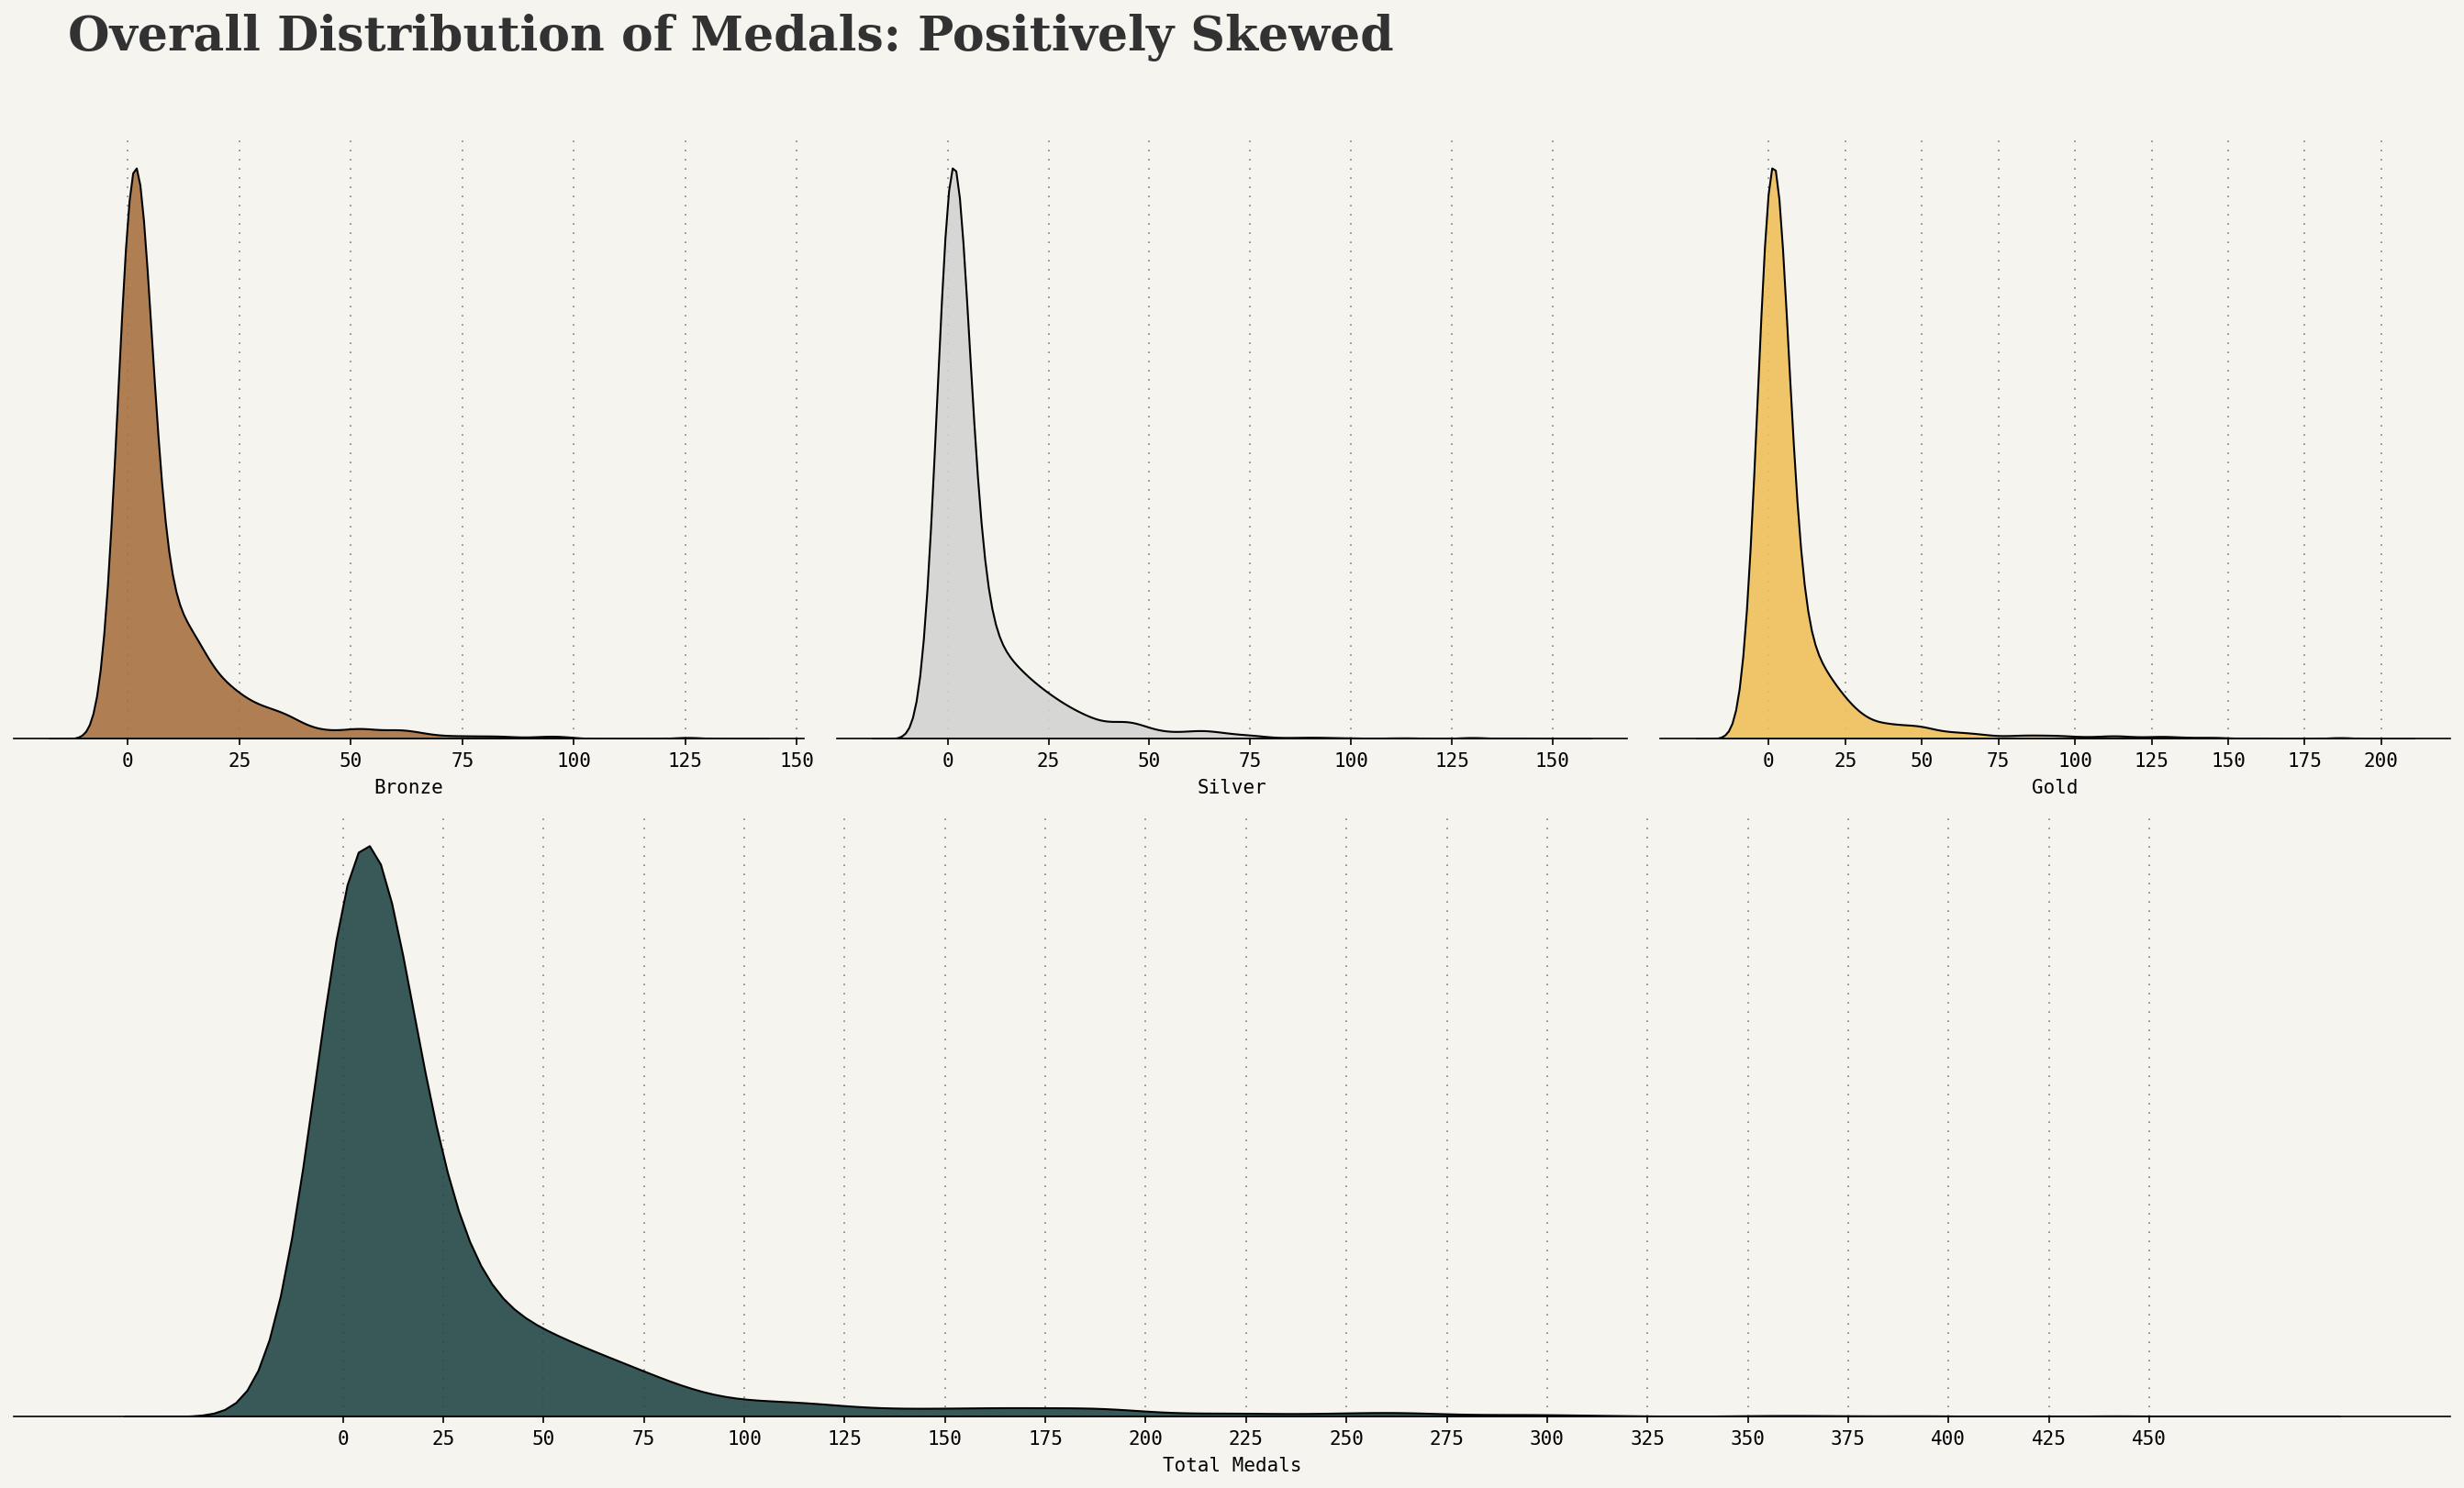

In [30]:
# Wrote this for 4 variables

fig = plt.figure(figsize=(18,10), facecolor=background_color)

colors = ['#a97142', 'lightgray', '#f0c05a', '#244747']

num = 0
variables = ['Bronze', 'Silver', 'Gold', 'Total Medals']

plots = [(0,0), (0,1), (0,2), (1,0)]

data = df_new

for item in variables:
    
    if plots[num] == plots[-1]:
        colspan=3
    else: 
        colspan=1
        
    plt.subplot2grid((2,3), (plots[num]), colspan=colspan)
    
    ax = sns.kdeplot(data=data, x=item,color=colors[num],shade=True,  alpha=0.9, ec='black', cut=5)
    ax.set_facecolor(background_color)
    ax.tick_params(axis='y', left=False)
    ax.get_yaxis().set_visible(False)
    ax.set_axisbelow(True)
    ax.set_xlabel(item)
    ax.grid(which='major', axis='x', zorder=5, color='gray', linestyle=':', dashes=(1,5))
    for s in ["top","right","left"]:
        ax.spines[s].set_visible(False)
    
    plt.xticks(list(np.arange(0,data[item].max()+25,25)))
        
    num +=1 
    
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

fig.text(0.03,1.05, 'Overall Distribution of Medals: Positively Skewed', fontsize=25,fontweight='bold',fontfamily='serif',color='#323232')

    
plt.tight_layout()
plt.show()

**What does this show us?**

We note that the medals are not distributed normally. They are positively skewed. **To mitigate against this, I will take the natural log of the total medals.**

In [31]:
host_list = list(df_new.query("Is_Host == 1")['Host_Country'].value_counts().index)

df_new['Total_Medals_NaturalLog'] = np.log(df_new['Total Medals'])

Not_hosting_samples = df_new[df_new['region'].isin(host_list)].query("Is_Host == 0")['Total_Medals_NaturalLog'].count()
hosting_samples = df_new[df_new['region'].isin(host_list)].query("Is_Host == 1")['Total_Medals_NaturalLog'].count()

Not_hosting_mean = df_new[df_new['region'].isin(host_list)].query("Is_Host == 0")['Total_Medals_NaturalLog'].mean()
hosting_mean = df_new[df_new['region'].isin(host_list)].query("Is_Host == 1")['Total_Medals_NaturalLog'].mean()

Not_hosting_std = df_new[df_new['region'].isin(host_list)].query("Is_Host == 0")['Total_Medals_NaturalLog'].std()
hosting_std = df_new[df_new['region'].isin(host_list)].query("Is_Host == 1")['Total_Medals_NaturalLog'].std()

In [32]:
print(color_font.S+"Key Statistics"+color_font.E)
print("Mean Natural Log of Total Medals when Not Hosting:\n",Not_hosting_mean)
print("Mean Natural Log of Total Medals when Hosting:\n",hosting_mean,"\n")


Not_hosting_std_error = Not_hosting_std/np.sqrt(Not_hosting_samples)
print("Standard Error of Natural Log of Total Medals when Not Hosting:\n",Not_hosting_std_error)

hosting_std_error = hosting_std/np.sqrt(hosting_samples)
print("Standard Error of Natural Log of Total Medals when Not Hosting:\n",hosting_std_error)

Key Statistics
Mean Natural Log of Total Medals when Not Hosting:
 3.086281690114538
Mean Natural Log of Total Medals when Hosting:
 4.566512430214569 

Standard Error of Natural Log of Total Medals when Not Hosting:
 0.06927049040753176
Standard Error of Natural Log of Total Medals when Not Hosting:
 0.19153671012884033


**Is this difference enough to declare that the two means are from different distributions?**

In [33]:
top = (hosting_mean-Not_hosting_mean)

bott1 = Not_hosting_std**2/Not_hosting_samples

bott2 = hosting_std**2/hosting_samples

print(color_font.S+"Standard Errors between means"+color_font.E)
print(top/(np.sqrt(bott1 + bott2)))

Standard Errors between means
7.267505655549315


This means that it is **incredibly** unlikely that the two means are from the same populations.

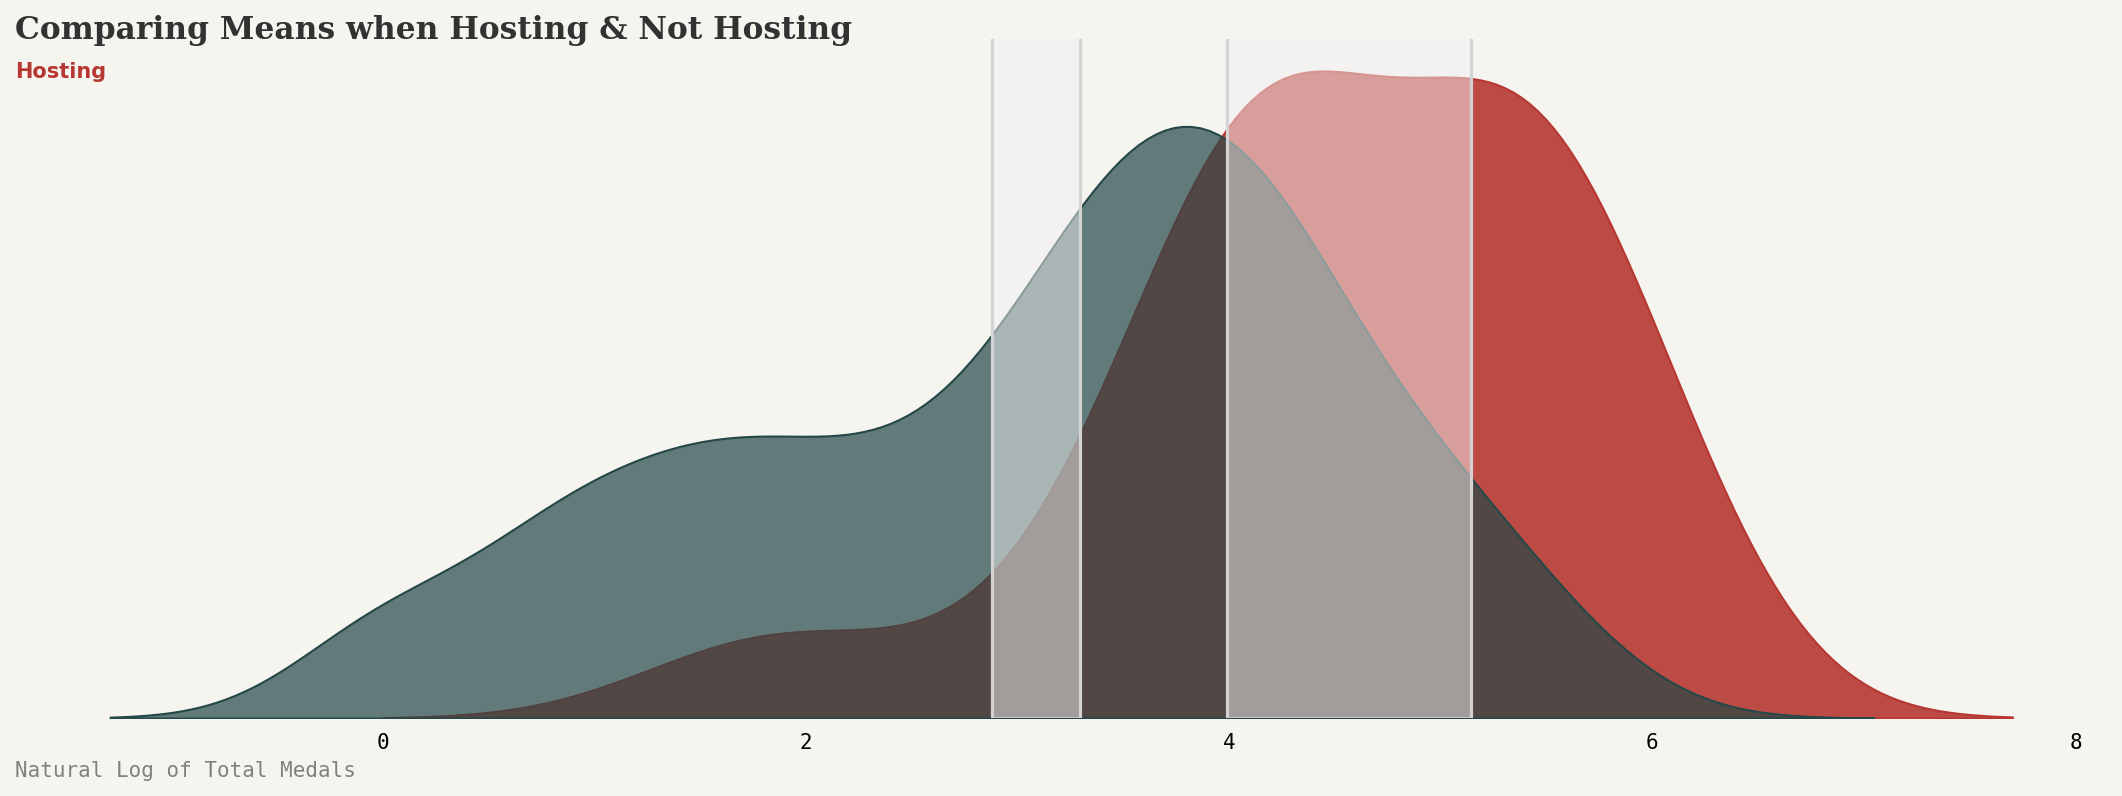

In [34]:
fig, ax = plt.subplots(1,1, figsize=(18,6), facecolor=background_color)
ax.set_facecolor(background_color)
sns.kdeplot(data=df_new[df_new['region'].isin(host_list)].query("Is_Host == 1"), x='Total_Medals_NaturalLog',shade=True,color='#B73832',alpha=0.9, ax=ax)
sns.kdeplot(data=df_new[df_new['region'].isin(host_list)].query("Is_Host == 0"), x='Total_Medals_NaturalLog', shade=True, color='#244747',alpha=0.7, ax=ax)

ax.axvline(color='lightgray',x=Not_hosting_mean+(3*Not_hosting_std_error))
ax.axvline(color='lightgray',x=Not_hosting_mean-(3*Not_hosting_std_error))
ax.axvspan(Not_hosting_mean-(3*Not_hosting_std_error), Not_hosting_mean+(3*Not_hosting_std_error), alpha=0.5, color='#f3f2f1')

#ax.axvline(x=Not_hosting_mean)

#ax.axvline(x=hosting_mean)
ax.axvline(color='lightgray',x=hosting_mean+(3*hosting_std_error))
ax.axvline(color='lightgray',x=hosting_mean-(3*hosting_std_error))
ax.axvspan(hosting_mean-(3*hosting_std_error), hosting_mean+(3*hosting_std_error), alpha=0.5, color='#f3f2f1')

for s in ['top','left', 'bottom', 'right']:
    ax.spines[s].set_visible(False)
    
ax.set_xlabel("Natural Log of Total Medals",fontfamily='monospace',loc='left',color='gray')
ax.get_yaxis().set_visible(False)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 


Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart,Yend, 'Comparing Means when Hosting & Not Hosting', fontsize=15,fontweight='bold',fontfamily='serif',color='#323232')
ax.text(Xstart,Yend-0.02, 'Hosting', fontsize=10,fontweight='bold',fontfamily='sansserif',color='#B73832')



plt.show()


**What does this show us?**

Above I have plotted the distributions of the natural log of the mean total medals host nations have acheived when they host, and when they do not host.

The grey boxes reprseent **3 standard errors above & below the mean values**. We note that these areas do not overlap. This suggests that the liklihood that hosting does not imprive performance is extremely small. In fact, it is overwhelmingly small.

In [35]:
from scipy.stats import ttest_ind

print(color_font.S+"T-Test"+color_font.E)
# compare samples
stat, p = ttest_ind(df_new[df_new['region'].isin(host_list)].query("Is_Host == 0")['Total_Medals_NaturalLog'], df_new[df_new['region'].isin(host_list)].query("Is_Host == 1")['Total_Medals_NaturalLog'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

T-Test
Statistics=-5.583, p=0.000
Different distributions (reject H0)


Based on the tests above, it appears that we can reject the null hypothesis that hosting has no impact on performance.

# **Work in Progress**